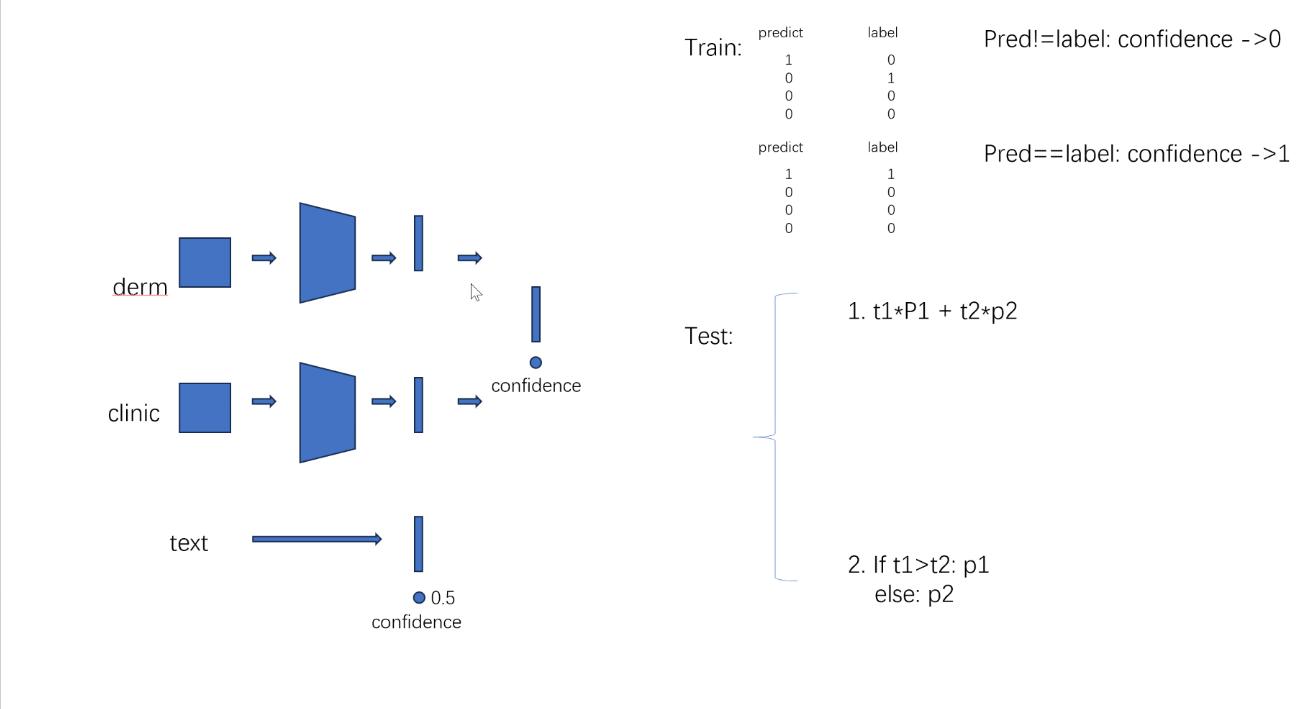

In [1]:
from utils import Logger,adjust_learning_rate,CreateLogger,create_cosine_learning_schedule,encode_test_label,set_seed
from model import Resnet_with_uncertainty#不确定度
from dependency import *
from torch import optim
from torchcontrib.optim import SWA
from dataloader import generate_dataloader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error # 均方误差

In [2]:
import torch.nn.functional as F
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import roc_auc_score,accuracy_score, roc_curve,auc,average_precision_score,precision_recall_curve
import cv2
from dependency import *
import pandas as pd
from utils import encode_test_label,Logger,encode_meta_choosed_label,encode_meta_label
from tqdm import tqdm_notebook  

test_index_df = pd.read_csv(test_index_path)
train_index_df = pd.read_csv(train_index_path)
val_index_df = pd.read_csv(val_index_path)

train_index_list = list(train_index_df['indexes'])
val_index_list = list(val_index_df['indexes'])
test_index_list = list(test_index_df['indexes'])

train_index_list_1 = train_index_list[0:206]
train_index_list_2 = train_index_list[206:]

df = pd.read_csv(img_info_path)

In [3]:
from tensorflow.keras.utils import to_categorical
import pandas as pd
from dependency import *

In [4]:
def get_label_list(image_index_list):
    diag_label_list = []
    pn_label_list = []
    str_label_list = []
    pig_label_list = []
    rs_label_list = []
    dag_label_list = []
    bwv_label_list = []
    vs_label_list = []
    meta_list = []
    meta_list_one_hot = []
    
    img_feature = []
    img_hf_feature = []
    img_vf_feature = []
    img_vhf_feature = []

    from sklearn.decomposition import PCA

    from tqdm import tqdm_notebook,tqdm
    for index_num in tqdm(image_index_list):
    #index_num = test_index_list[100]
        img_info = df[index_num:index_num+1]
        clinic_path = img_info['clinic']
        dermoscopy_path = img_info['derm']
        source_dir = '../release_v0/release_v0/images/'
        clinic_img = cv2.imread(source_dir+clinic_path[index_num])
        dermoscopy_img = cv2.imread(source_dir+dermoscopy_path[index_num])
        '''这里对于metadata需要变更'''
        meta_vector_one_hot,meta_vector = encode_meta_choosed_label(img_info,index_num)
        
        [diagnosis_label,pigment_network_label,streaks_label,pigmentation_label,regression_structures_label,
         dots_and_globules_label,blue_whitish_veil_label, vascular_structures_label],[diagnosis_label_one_hot,pigment_network_label_one_hot,
        streaks_label_one_hot,pigmentation_label_one_hot,regression_structures_label_one_hot,
        dots_and_globules_label_one_hot,blue_whitish_veil_label_one_hot, vascular_structures_label_one_hot] = encode_test_label(img_info,index_num)

        diag_label_list.append(diagnosis_label)
        pn_label_list.append(pigment_network_label)
        str_label_list.append(streaks_label)
        pig_label_list.append(pigmentation_label)
        rs_label_list.append(regression_structures_label)
        dag_label_list.append(dots_and_globules_label)
        bwv_label_list.append(blue_whitish_veil_label)
        vs_label_list.append(vascular_structures_label)
        meta_list.append(meta_vector)
        meta_list_one_hot.append(meta_vector_one_hot)



    label_dict ={'diag':diag_label_list,
                 'pn':pn_label_list,
                 'str':str_label_list,
                 'pig':pig_label_list,
                 'rs':rs_label_list,
                 'dag':dag_label_list,
                 'bwv':bwv_label_list,
                 'vs':vs_label_list}
    
    return label_dict,meta_list,meta_list_one_hot

# MLP and regression

In [5]:
#model here！
from model import MLP_with_uncertainty,MyCNN,Resnet_with_uncertainty,ResNet50_uncertainty
import torch.nn as nn

In [6]:
def train(net, train_dataloader, model_name):
    net.set_mode("train")
    train_loss = 0
    train_dia_acc = 0
    train_sps_acc = 0
    for index,(clinic_image, derm_image, meta_data, label) in enumerate(train_dataloader):
        opt.zero_grad()
        clinic_image = clinic_image.cuda()
        derm_image = derm_image.cuda()
      
        meta_data = meta_data.float().cuda()
        #print("meta_data.size:",meta_data.size())
        #Diagnostic label
        diagnosis_label = label[0].long().cuda()
        #Seven-point Checklist labels
        pn_label = label[1].long().cuda()
        str_label = label[2].long().cuda()
        pig_label = label[3].long().cuda()
        rs_label = label[4].long().cuda()
        dag_label = label[5].long().cuda()
        bwv_label = label[6].long().cuda()
        vs_label = label[7].long().cuda()
        
        #print("meta_data:",meta_data,meta_data.shape)
        #uncertainty
        [   (logit_diagnosis_clic,logit_pn_clic,logit_str_clic,logit_pig_clic,logit_rs_clic,logit_dag_clic,logit_bwv_clic,logit_vs_clic,logit_uncertainty_clic),
            (logit_diagnosis_derm,logit_pn_derm,logit_str_derm,logit_pig_derm,logit_rs_derm,logit_dag_derm,logit_bwv_derm,logit_vs_derm,logit_uncertainty_derm),
            (logit_diagnosis, logit_pn, logit_str, logit_pig, logit_rs, logit_dag, logit_bwv,logit_vs,logit_uncertainty),
            (x_clic_cos,x_derm_cos)] = net2((clinic_image,derm_image))
        #print("logit_diagnosis:",logit_diagnosis)
        logit_diagnosis = torch.nn.Softmax(dim=1)(logit_diagnosis)
        logit_pn = torch.nn.Softmax(dim=1)(logit_pn)
        logit_str = torch.nn.Softmax(dim=1)(logit_pn)
        logit_pig = torch.nn.Softmax(dim=1)(logit_pig)
        logit_rs = torch.nn.Softmax(dim=1)(logit_rs)
        logit_dag = torch.nn.Softmax(dim=1)(logit_dag)
        logit_bwv = torch.nn.Softmax(dim=1)(logit_bwv)
        logit_vs = torch.nn.Softmax(dim=1)(logit_vs)
        
        meta_data = meta_data.squeeze()
        meta_data = torch.cat([meta_data,logit_diagnosis,logit_pn,logit_str,logit_pig,logit_rs,logit_dag,logit_bwv,logit_vs],dim=1)
        meta_data = meta_data.unsqueeze(dim=1)
        
        [(logit_diagnosis, logit_pn, logit_str, logit_pig, logit_rs, logit_dag, logit_bwv,logit_vs,logit_uncertainty)] = net(meta_data)
        
        prediction1 = torch.argmax(torch.nn.Softmax(dim=1)(logit_diagnosis),dim = 1)
        #print("logit_diagnosis:",logit_diagnosis,"+",logit_diagnosis.shape)
        #print("prediction1:",prediction1,"+",prediction1.shape)
        #print("label1:",diagnosis_label)
        
        prediction2 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pn),dim = 1)

        prediction3 = torch.argmax(torch.nn.Softmax(dim=1)(logit_str),dim = 1)

        prediction4 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pig),dim = 1)
    
        prediction5 = torch.argmax(torch.nn.Softmax(dim=1)(logit_rs),dim = 1)

        prediction6 = torch.argmax(torch.nn.Softmax(dim=1)(logit_dag),dim = 1)
        
        prediction7 = torch.argmax(torch.nn.Softmax(dim=1)(logit_bwv),dim = 1)
        
        prediction8 = torch.argmax(torch.nn.Softmax(dim=1)(logit_vs),dim = 1)
        
        prediction1 = prediction1.unsqueeze(0)
        prediction2 = prediction2.unsqueeze(0)
        prediction3 = prediction3.unsqueeze(0)
        prediction4 = prediction4.unsqueeze(0)
        prediction5 = prediction5.unsqueeze(0)
        prediction6 = prediction6.unsqueeze(0)
        prediction7 = prediction7.unsqueeze(0)
        prediction8 = prediction8.unsqueeze(0)
        prediction1 = np.array(prediction1.cpu(),dtype="int")
        prediction2 = np.array(prediction2.cpu(),dtype="int")
        prediction3 = np.array(prediction3.cpu(),dtype="int")
        prediction4 = np.array(prediction4.cpu(),dtype="int")
        prediction5 = np.array(prediction5.cpu(),dtype="int")
        prediction6 = np.array(prediction6.cpu(),dtype="int")
        prediction7 = np.array(prediction7.cpu(),dtype="int")
        prediction8 = np.array(prediction8.cpu(),dtype="int")
        
        p = np.hstack((prediction1.T,prediction2.T))
        p = np.hstack((p,prediction3.T))
        p = np.hstack((p,prediction4.T))
        p = np.hstack((p,prediction5.T))
        p = np.hstack((p,prediction6.T))
        p = np.hstack((p,prediction7.T))
        p = np.hstack((p,prediction8.T))
        p = torch.tensor(p)
        
        diagnosis_label_t = diagnosis_label.unsqueeze(0)
        pn_label_t = pn_label.unsqueeze(0)
        str_label_t = str_label.unsqueeze(0)
        pig_label_t = pig_label.unsqueeze(0)
        rs_label_t = rs_label.unsqueeze(0)
        dag_label_t = dag_label.unsqueeze(0)
        bwv_label_t = bwv_label.unsqueeze(0)
        vs_label_t = vs_label.unsqueeze(0)
        pn_label_t = np.array(pn_label_t.cpu(),dtype="int")
        str_label_t = np.array(str_label_t.cpu(),dtype="int")
        pig_label_t = np.array(pig_label_t.cpu(),dtype="int")
        rs_label_t = np.array(rs_label_t.cpu(),dtype="int")
        dag_label_t = np.array(dag_label_t.cpu(),dtype="int")
        bwv_label_t = np.array(bwv_label_t.cpu(),dtype="int")
        vs_label_t = np.array(vs_label_t.cpu(),dtype="int")
        diagnosis_label_t = np.array(diagnosis_label_t.cpu(),dtype="int")
        t = np.hstack((diagnosis_label_t.T,pn_label_t.T))
        t = np.hstack((t,str_label_t.T))
        t = np.hstack((t,pig_label_t.T))
        t = np.hstack((t,rs_label_t.T))
        t = np.hstack((t,dag_label_t.T))
        t = np.hstack((t,bwv_label_t.T))
        t = np.hstack((t,vs_label_t.T))
        t = torch.tensor(t)
        
        #print("t:",t)
        #print("p:",p)
        
        certainty_b = (t == p).long()
        #print("certainty_b:",certainty_b,certainty_b.shape)
        certainty_ones = torch.tensor(np.ones(certainty_b.size()))
        uncertainty_label = []
        for i in range(certainty_ones.size(0)):
            mean_squared_error_tmp = mean_squared_error(certainty_ones[i,:],certainty_b[i,:])
            if mean_squared_error_tmp >= 0.6:
                mean_squared_error_tmp = 1
            else:
                mean_squared_error_tmp = 0
            uncertainty_label.append([mean_squared_error_tmp]) # bigger uncertainty, bigger MSE, means the prediction is less accurate. 
        uncertainty_label = torch.tensor(uncertainty_label)
        
        #print("uncertainty_label:",uncertainty_label)
        #print("logit_uncertainty:",logit_uncertainty)
            
        #uncertainty
        logit_uncertainty = logit_uncertainty.float().cuda()
        uncertainty_label = uncertainty_label.float().cuda()
        
        loss = torch.div(
          net.criterion(logit_diagnosis, diagnosis_label)
        + net.criterion(logit_pn, pn_label)
        + net.criterion(logit_str, str_label)
        + net.criterion(logit_pig, pig_label)
        + net.criterion(logit_rs, rs_label)
        + net.criterion(logit_dag, dag_label)
        + net.criterion(logit_bwv, bwv_label)
        + net.criterion(logit_vs, vs_label)
        + net.criterion_MSE(logit_uncertainty,uncertainty_label), 9)
        
        dia_acc_all = torch.div(net.metric(logit_diagnosis,diagnosis_label),int(meta_data.size(0)))
        sps_acc_all = torch.div(  net.metric(logit_pn,pn_label)
                                + net.metric(logit_str,str_label)
                                + net.metric(logit_pig,pig_label)
                                + net.metric(logit_rs,rs_label)
                                + net.metric(logit_dag,dag_label)
                                + net.metric(logit_bwv,bwv_label)
                                + net.metric(logit_vs,vs_label),int(7 * meta_data.size(0)))
        loss.backward()
        opt.step()

        train_loss += loss.item()
        train_dia_acc += dia_acc_all.item()
        train_sps_acc += sps_acc_all.item()

    train_loss = train_loss / (index + 1) # Because the index start with the value 0f zero
    train_dia_acc = train_dia_acc / (index + 1)
    train_sps_acc = train_sps_acc / (index + 1)

    return train_loss,train_dia_acc,train_sps_acc

In [7]:
def validation(net, val_dataloader, model_name):
    net.set_mode("valid")
    val_loss = 0
    val_dia_acc = 0
    val_sps_acc = 0
    for index,(clinic_image, derm_image, meta_data, label) in enumerate(val_dataloader):
        opt.zero_grad()
        clinic_image = clinic_image.cuda()
        derm_image = derm_image.cuda()
        meta_data = meta_data.float().cuda()
        
        #Diagnostic label
        diagnosis_label = label[0].long().cuda()
        #Seven-point Checklist labels
        pn_label = label[1].long().cuda()
        str_label = label[2].long().cuda()
        pig_label = label[3].long().cuda()
        rs_label = label[4].long().cuda()
        dag_label = label[5].long().cuda()
        bwv_label = label[6].long().cuda()
        vs_label = label[7].long().cuda()
        
        with torch.no_grad():
            
            #uncertainty
            [   (logit_diagnosis_clic,logit_pn_clic,logit_str_clic,logit_pig_clic,logit_rs_clic,logit_dag_clic,logit_bwv_clic,logit_vs_clic,logit_uncertainty_clic),
            (logit_diagnosis_derm,logit_pn_derm,logit_str_derm,logit_pig_derm,logit_rs_derm,logit_dag_derm,logit_bwv_derm,logit_vs_derm,logit_uncertainty_derm),
            (logit_diagnosis, logit_pn, logit_str, logit_pig, logit_rs, logit_dag, logit_bwv,logit_vs,logit_uncertainty),
            (x_clic_cos,x_derm_cos)] = net2((clinic_image,derm_image))
            #print("logit_diagnosis:",logit_diagnosis)
            logit_diagnosis = torch.nn.Softmax(dim=1)(logit_diagnosis)
            logit_pn = torch.nn.Softmax(dim=1)(logit_pn)
            logit_str = torch.nn.Softmax(dim=1)(logit_pn)
            logit_pig = torch.nn.Softmax(dim=1)(logit_pig)
            logit_rs = torch.nn.Softmax(dim=1)(logit_rs)
            logit_dag = torch.nn.Softmax(dim=1)(logit_dag)
            logit_bwv = torch.nn.Softmax(dim=1)(logit_bwv)
            logit_vs = torch.nn.Softmax(dim=1)(logit_vs)
            
            meta_data = meta_data.squeeze()
            meta_data = torch.cat([meta_data,logit_diagnosis,logit_pn,logit_str,logit_pig,logit_rs,logit_dag,logit_bwv,logit_vs],dim=1)
            meta_data = meta_data.unsqueeze(dim=1)
            [(logit_diagnosis, logit_pn, logit_str, logit_pig, logit_rs, logit_dag, logit_bwv,logit_vs,logit_uncertainty)] = net(meta_data)
            
            prediction1 = torch.argmax(torch.nn.Softmax(dim=1)(logit_diagnosis),dim = 1)

            prediction2 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pn),dim = 1)

            prediction3 = torch.argmax(torch.nn.Softmax(dim=1)(logit_str),dim = 1)

            prediction4 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pig),dim = 1)

            prediction5 = torch.argmax(torch.nn.Softmax(dim=1)(logit_rs),dim = 1)

            prediction6 = torch.argmax(torch.nn.Softmax(dim=1)(logit_dag),dim = 1)

            prediction7 = torch.argmax(torch.nn.Softmax(dim=1)(logit_bwv),dim = 1)

            prediction8 = torch.argmax(torch.nn.Softmax(dim=1)(logit_vs),dim = 1)

            prediction1 = prediction1.unsqueeze(0)
            prediction2 = prediction2.unsqueeze(0)
            prediction3 = prediction3.unsqueeze(0)
            prediction4 = prediction4.unsqueeze(0)
            prediction5 = prediction5.unsqueeze(0)
            prediction6 = prediction6.unsqueeze(0)
            prediction7 = prediction7.unsqueeze(0)
            prediction8 = prediction8.unsqueeze(0)
            prediction1 = np.array(prediction1.cpu(),dtype="int")
            prediction2 = np.array(prediction2.cpu(),dtype="int")
            prediction3 = np.array(prediction3.cpu(),dtype="int")
            prediction4 = np.array(prediction4.cpu(),dtype="int")
            prediction5 = np.array(prediction5.cpu(),dtype="int")
            prediction6 = np.array(prediction6.cpu(),dtype="int")
            prediction7 = np.array(prediction7.cpu(),dtype="int")
            prediction8 = np.array(prediction8.cpu(),dtype="int")

            p = np.hstack((prediction1.T,prediction2.T))
            p = np.hstack((p,prediction3.T))
            p = np.hstack((p,prediction4.T))
            p = np.hstack((p,prediction5.T))
            p = np.hstack((p,prediction6.T))
            p = np.hstack((p,prediction7.T))
            p = np.hstack((p,prediction8.T))
            p = torch.tensor(p)

            diagnosis_label_t = diagnosis_label.unsqueeze(0)
            pn_label_t = pn_label.unsqueeze(0)
            str_label_t = str_label.unsqueeze(0)
            pig_label_t = pig_label.unsqueeze(0)
            rs_label_t = rs_label.unsqueeze(0)
            dag_label_t = dag_label.unsqueeze(0)
            bwv_label_t = bwv_label.unsqueeze(0)
            vs_label_t = vs_label.unsqueeze(0)
            pn_label_t = np.array(pn_label_t.cpu(),dtype="int")
            str_label_t = np.array(str_label_t.cpu(),dtype="int")
            pig_label_t = np.array(pig_label_t.cpu(),dtype="int")
            rs_label_t = np.array(rs_label_t.cpu(),dtype="int")
            dag_label_t = np.array(dag_label_t.cpu(),dtype="int")
            bwv_label_t = np.array(bwv_label_t.cpu(),dtype="int")
            vs_label_t = np.array(vs_label_t.cpu(),dtype="int")
            diagnosis_label_t = np.array(diagnosis_label_t.cpu(),dtype="int")
            t = np.hstack((diagnosis_label_t.T,pn_label_t.T))
            t = np.hstack((t,str_label_t.T))
            t = np.hstack((t,pig_label_t.T))
            t = np.hstack((t,rs_label_t.T))
            t = np.hstack((t,dag_label_t.T))
            t = np.hstack((t,bwv_label_t.T))
            t = np.hstack((t,vs_label_t.T))
            t = torch.tensor(t)
            
            certainty_b = (t == p).long()
            certainty_ones = torch.tensor(np.ones(certainty_b.size()))
            uncertainty_label = []
            for i in range(certainty_ones.size(0)):
                mean_squared_error_tmp = mean_squared_error(certainty_ones[i,:],certainty_b[i,:])
                if mean_squared_error_tmp >= 0.6:
                    mean_squared_error_tmp = 1
                else:
                    mean_squared_error_tmp = 0
                uncertainty_label.append([mean_squared_error_tmp]) # bigger uncertainty, bigger MSE, means the prediction is less accurate. 
            uncertainty_label = torch.tensor(uncertainty_label)
            
            #uncertainty
            logit_uncertainty = logit_uncertainty.float().cuda()
            uncertainty_label = uncertainty_label.float().cuda()
            loss = torch.div(
              net.criterion(logit_diagnosis, diagnosis_label)
            + net.criterion(logit_pn, pn_label)
            + net.criterion(logit_str, str_label)
            + net.criterion(logit_pig, pig_label)
            + net.criterion(logit_rs, rs_label)
            + net.criterion(logit_dag, dag_label)
            + net.criterion(logit_bwv, bwv_label)
            + net.criterion(logit_vs, vs_label)
            + net.criterion_MSE(logit_uncertainty,uncertainty_label), 9)

            dia_acc_all = torch.div(net.metric(logit_diagnosis,diagnosis_label),int(meta_data.size(0)))
            sps_acc_all = torch.div(  net.metric(logit_pn,pn_label)
                                    + net.metric(logit_str,str_label)
                                    + net.metric(logit_pig,pig_label)
                                    + net.metric(logit_rs,rs_label)
                                    + net.metric(logit_dag,dag_label)
                                    + net.metric(logit_bwv,bwv_label)
                                    + net.metric(logit_vs,vs_label),int(7 * meta_data.size(0)))
            

        val_loss += loss.item()
        val_dia_acc += dia_acc_all.item()
        val_sps_acc += sps_acc_all.item()

    val_loss = val_loss / (index + 1) # Because the index start with the value 0f zero
    val_dia_acc = val_dia_acc / (index + 1)
    val_sps_acc = val_sps_acc / (index + 1)

    return val_loss,val_dia_acc,val_sps_acc

In [8]:
def run_train(model_name,mode,i):
    log.write('** start MLP(uncertainty) training here! **\n')
    #best_acc = 0
    es = 0
    patience = 50
    best_mean_acc = 0 
    best_loss = 300
    
    for epoch in range(epochs):
        swa_lr = cosine_learning_schedule[epoch]
        adjust_learning_rate(opt, swa_lr)

        # train_mode
        train_loss,train_dia_acc,train_sps_acc=train(net, train_dataloader,model_name)
        log.write('Round: {}, epoch: {}, Train Loss: {:.4f}, Train Dia Acc: {:.4f}, Train SPS Acc: {:.4f}\n'.format(i, epoch, train_loss,
                                                                                                         train_dia_acc,
                                                                                                         train_sps_acc))

        # validation mode
        val_loss,val_dia_acc,val_sps_acc = validation(net, val_dataloader,model_name)
        
        val_acc = (val_dia_acc + val_sps_acc) / 2
        val_mean_acc = (val_dia_acc*1 + val_sps_acc*7)/8
        
        log.write('Round: {}, epoch: {}, Valid Loss: {:.4f}, Valid Dia Acc: {:.4f}, Valid SPS Acc: {:.4f}\n'.format(i, epoch, val_loss,
                                                                                                         val_dia_acc,
                                                                                                         val_sps_acc))

     
        if val_mean_acc > best_mean_acc:
            es = 0
            best_mean_acc = val_mean_acc
            torch.save(net.state_dict(), out_dir + '/checkpoint/{}_model.pth'.format('best_mean_acc'))
            log.write('Current Best Mean Acc is {}'.format(best_mean_acc))
        #  else:
        #      es += 1
        #      print("Counter {} of {}".format(es,patience))
          
        #      if es > patience:
        #          print("Early stopping with best_mean_acc: {:.4f}".format(best_mean_acc), "and val_mean_acc for this epoch: {:.4f}".format(val_mean_acc))
        #          break
  
  
        if epoch > (epochs - swa_epoch) and epoch % 1 == 0:
            opt.update_swa()
            log.write('SWA Epoch: {}'.format(epoch))

    torch.save(net.state_dict(), out_dir+'/swa_{}_MLP_model.pth'.format(mode))

In [9]:
if __name__ == '__main__':
    # Hyperparameters
    mode = 'multimodal'
    tech = "uncertainty"
    model_name = "MLP"
    shape = (224, 224)
    batch_size = 5
    num_workers = 0
    data_mode = 'Normal'
    deterministic = True
    if deterministic:
        if data_mode == 'Normal':
            random_seeds = 170
        elif data_mode == 'self_evaluated':
            random_seeds = 183
    rounds = 5
    lr = 4e-4###
    epochs = 500
    swa_epoch = 250    

    train_dataloader, val_dataloader = generate_dataloader(shape, batch_size, num_workers, data_mode,"concat")
    
    for i in range(rounds):
        if deterministic:
            set_seed(random_seeds + i)
      # create logger
        print(random_seeds+i)
        log, out_dir = CreateLogger(mode, model_name,i,data_mode)
        #network 
        net = MLP_with_uncertainty(class_list).cuda()
        
        weight_file = './{}_{}_{}_weight_file/{}/checkpoint/best_mean_acc_model.pth'.format("multimodal(copy2)","Resnet_cos-loss and concat","Normal",i)
        print(weight_file)
        net2 = Resnet_with_uncertainty(class_list).cuda()
        net2.load_state_dict(torch.load(weight_file))
      # create optimizer
        optimizer = optim.Adam(net.parameters(), lr=lr,weight_decay=5e-5)   #weight_decay   #5e-5
        opt = SWA(optimizer)  
      # create learning schedule
        cosine_learning_schedule = create_cosine_learning_schedule(epochs, lr)
        run_train(model_name,mode,i)

170

--- [START IDENTIFIER] ----------------------------------------------------------------


	out_dir      = ./multimodal_MLP_Normal_weight_file/0/



	<additional comments> ...  

	  - multimodal MLP  

	  - simple augmentation 



./multimodal(copy2)_Resnet_cos-loss and concat_Normal_weight_file/0/checkpoint/best_mean_acc_model.pth
** start MLP(uncertainty) training here! **

Round: 0, epoch: 0, Train Loss: 1.0060, Train Dia Acc: 0.2787, Train SPS Acc: 0.4239

Round: 0, epoch: 0, Valid Loss: 0.8983, Valid Dia Acc: 0.5057, Valid SPS Acc: 0.6037

Current Best Mean Acc is 0.591463433896623
Round: 0, epoch: 1, Train Loss: 0.8626, Train Dia Acc: 0.4980, Train SPS Acc: 0.5572

Round: 0, epoch: 1, Valid Loss: 0.8297, Valid Dia Acc: 0.6341, Valid SPS Acc: 0.6611

Current Best Mean Acc is 0.6577235945932022
Round: 0, epoch: 2, Train Loss: 0.7762, Train Dia Acc: 0.5743, Train SPS Acc: 0.6327

Round: 0, epoch: 2, Valid Loss: 0.7601, Valid Dia Acc: 0.6146, Valid SPS Acc: 0.6943

Current Best M

Round: 0, epoch: 43, Train Loss: 0.5683, Train Dia Acc: 0.6924, Train SPS Acc: 0.7486

Round: 0, epoch: 43, Valid Loss: 0.6224, Valid Dia Acc: 0.6390, Valid SPS Acc: 0.6994

Round: 0, epoch: 44, Train Loss: 0.5264, Train Dia Acc: 0.7205, Train SPS Acc: 0.7711

Round: 0, epoch: 44, Valid Loss: 0.6181, Valid Dia Acc: 0.6309, Valid SPS Acc: 0.7015

Round: 0, epoch: 45, Train Loss: 0.5411, Train Dia Acc: 0.6980, Train SPS Acc: 0.7573

Round: 0, epoch: 45, Valid Loss: 0.6130, Valid Dia Acc: 0.6520, Valid SPS Acc: 0.7094

Round: 0, epoch: 46, Train Loss: 0.5254, Train Dia Acc: 0.7406, Train SPS Acc: 0.7681

Round: 0, epoch: 46, Valid Loss: 0.6119, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7041

Round: 0, epoch: 47, Train Loss: 0.5443, Train Dia Acc: 0.7446, Train SPS Acc: 0.7504

Round: 0, epoch: 47, Valid Loss: 0.6162, Valid Dia Acc: 0.6211, Valid SPS Acc: 0.7022

Round: 0, epoch: 48, Train Loss: 0.5162, Train Dia Acc: 0.7229, Train SPS Acc: 0.7675

Round: 0, epoch: 48, Valid Loss: 0.6023, Va

Round: 0, epoch: 89, Valid Loss: 0.5977, Valid Dia Acc: 0.6618, Valid SPS Acc: 0.7266

Round: 0, epoch: 90, Train Loss: 0.5162, Train Dia Acc: 0.7494, Train SPS Acc: 0.7697

Round: 0, epoch: 90, Valid Loss: 0.5805, Valid Dia Acc: 0.6715, Valid SPS Acc: 0.7340

Round: 0, epoch: 91, Train Loss: 0.5191, Train Dia Acc: 0.7309, Train SPS Acc: 0.7612

Round: 0, epoch: 91, Valid Loss: 0.5913, Valid Dia Acc: 0.6732, Valid SPS Acc: 0.7296

Round: 0, epoch: 92, Train Loss: 0.5107, Train Dia Acc: 0.7237, Train SPS Acc: 0.7753

Round: 0, epoch: 92, Valid Loss: 0.5848, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7173

Round: 0, epoch: 93, Train Loss: 0.5302, Train Dia Acc: 0.6988, Train SPS Acc: 0.7633

Round: 0, epoch: 93, Valid Loss: 0.6030, Valid Dia Acc: 0.6293, Valid SPS Acc: 0.7161

Round: 0, epoch: 94, Train Loss: 0.5168, Train Dia Acc: 0.7141, Train SPS Acc: 0.7676

Round: 0, epoch: 94, Valid Loss: 0.5846, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7287

Round: 0, epoch: 95, Train Loss: 0.5206, Tr

Round: 0, epoch: 136, Train Loss: 0.5251, Train Dia Acc: 0.7277, Train SPS Acc: 0.7648

Round: 0, epoch: 136, Valid Loss: 0.6019, Valid Dia Acc: 0.6829, Valid SPS Acc: 0.7208

Round: 0, epoch: 137, Train Loss: 0.5213, Train Dia Acc: 0.7534, Train SPS Acc: 0.7719

Round: 0, epoch: 137, Valid Loss: 0.6061, Valid Dia Acc: 0.6618, Valid SPS Acc: 0.7240

Round: 0, epoch: 138, Train Loss: 0.5033, Train Dia Acc: 0.7486, Train SPS Acc: 0.7764

Round: 0, epoch: 138, Valid Loss: 0.5992, Valid Dia Acc: 0.6764, Valid SPS Acc: 0.7196

Round: 0, epoch: 139, Train Loss: 0.5142, Train Dia Acc: 0.7261, Train SPS Acc: 0.7691

Round: 0, epoch: 139, Valid Loss: 0.6200, Valid Dia Acc: 0.6455, Valid SPS Acc: 0.7101

Round: 0, epoch: 140, Train Loss: 0.5018, Train Dia Acc: 0.7526, Train SPS Acc: 0.7726

Round: 0, epoch: 140, Valid Loss: 0.5886, Valid Dia Acc: 0.6862, Valid SPS Acc: 0.7257

Round: 0, epoch: 141, Train Loss: 0.5396, Train Dia Acc: 0.7301, Train SPS Acc: 0.7540

Round: 0, epoch: 141, Valid Loss

Round: 0, epoch: 183, Train Loss: 0.5253, Train Dia Acc: 0.7430, Train SPS Acc: 0.7605

Round: 0, epoch: 183, Valid Loss: 0.5926, Valid Dia Acc: 0.6634, Valid SPS Acc: 0.7292

Round: 0, epoch: 184, Train Loss: 0.5148, Train Dia Acc: 0.7542, Train SPS Acc: 0.7663

Round: 0, epoch: 184, Valid Loss: 0.5774, Valid Dia Acc: 0.6992, Valid SPS Acc: 0.7129

Round: 0, epoch: 185, Train Loss: 0.5067, Train Dia Acc: 0.7301, Train SPS Acc: 0.7731

Round: 0, epoch: 185, Valid Loss: 0.5979, Valid Dia Acc: 0.6715, Valid SPS Acc: 0.7178

Round: 0, epoch: 186, Train Loss: 0.5093, Train Dia Acc: 0.7454, Train SPS Acc: 0.7723

Round: 0, epoch: 186, Valid Loss: 0.5753, Valid Dia Acc: 0.6943, Valid SPS Acc: 0.7347

Round: 0, epoch: 187, Train Loss: 0.5230, Train Dia Acc: 0.7462, Train SPS Acc: 0.7689

Round: 0, epoch: 187, Valid Loss: 0.5765, Valid Dia Acc: 0.6553, Valid SPS Acc: 0.7259

Round: 0, epoch: 188, Train Loss: 0.5222, Train Dia Acc: 0.7189, Train SPS Acc: 0.7587

Round: 0, epoch: 188, Valid Loss

Round: 0, epoch: 229, Valid Loss: 0.5796, Valid Dia Acc: 0.6846, Valid SPS Acc: 0.7250

Round: 0, epoch: 230, Train Loss: 0.4855, Train Dia Acc: 0.7815, Train SPS Acc: 0.7819

Round: 0, epoch: 230, Valid Loss: 0.5881, Valid Dia Acc: 0.6439, Valid SPS Acc: 0.7196

Round: 0, epoch: 231, Train Loss: 0.4958, Train Dia Acc: 0.7687, Train SPS Acc: 0.7793

Round: 0, epoch: 231, Valid Loss: 0.5939, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7141

Round: 0, epoch: 232, Train Loss: 0.4970, Train Dia Acc: 0.7614, Train SPS Acc: 0.7829

Round: 0, epoch: 232, Valid Loss: 0.5871, Valid Dia Acc: 0.7089, Valid SPS Acc: 0.7157

Round: 0, epoch: 233, Train Loss: 0.4973, Train Dia Acc: 0.7695, Train SPS Acc: 0.7753

Round: 0, epoch: 233, Valid Loss: 0.5905, Valid Dia Acc: 0.6894, Valid SPS Acc: 0.7201

Round: 0, epoch: 234, Train Loss: 0.5260, Train Dia Acc: 0.7454, Train SPS Acc: 0.7639

Round: 0, epoch: 234, Valid Loss: 0.5698, Valid Dia Acc: 0.7073, Valid SPS Acc: 0.7285

Round: 0, epoch: 235, Train Loss

Round: 0, epoch: 274, Train Loss: 0.4949, Train Dia Acc: 0.7807, Train SPS Acc: 0.7882

Round: 0, epoch: 274, Valid Loss: 0.5972, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7159

SWA Epoch: 274
Round: 0, epoch: 275, Train Loss: 0.5129, Train Dia Acc: 0.7494, Train SPS Acc: 0.7644

Round: 0, epoch: 275, Valid Loss: 0.5803, Valid Dia Acc: 0.6732, Valid SPS Acc: 0.7273

SWA Epoch: 275
Round: 0, epoch: 276, Train Loss: 0.4855, Train Dia Acc: 0.7566, Train SPS Acc: 0.7740

Round: 0, epoch: 276, Valid Loss: 0.5927, Valid Dia Acc: 0.7252, Valid SPS Acc: 0.7164

SWA Epoch: 276
Round: 0, epoch: 277, Train Loss: 0.4942, Train Dia Acc: 0.7679, Train SPS Acc: 0.7756

Round: 0, epoch: 277, Valid Loss: 0.6043, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7113

SWA Epoch: 277
Round: 0, epoch: 278, Train Loss: 0.4953, Train Dia Acc: 0.7261, Train SPS Acc: 0.7717

Round: 0, epoch: 278, Valid Loss: 0.5900, Valid Dia Acc: 0.7024, Valid SPS Acc: 0.7271

SWA Epoch: 278
Round: 0, epoch: 279, Train Loss: 0.4994, Tra

Round: 0, epoch: 317, Train Loss: 0.4771, Train Dia Acc: 0.7735, Train SPS Acc: 0.7866

Round: 0, epoch: 317, Valid Loss: 0.5764, Valid Dia Acc: 0.7089, Valid SPS Acc: 0.7298

SWA Epoch: 317
Round: 0, epoch: 318, Train Loss: 0.5185, Train Dia Acc: 0.7309, Train SPS Acc: 0.7651

Round: 0, epoch: 318, Valid Loss: 0.6018, Valid Dia Acc: 0.6699, Valid SPS Acc: 0.7148

SWA Epoch: 318
Round: 0, epoch: 319, Train Loss: 0.4967, Train Dia Acc: 0.7526, Train SPS Acc: 0.7897

Round: 0, epoch: 319, Valid Loss: 0.5920, Valid Dia Acc: 0.6634, Valid SPS Acc: 0.7208

SWA Epoch: 319
Round: 0, epoch: 320, Train Loss: 0.4926, Train Dia Acc: 0.7598, Train SPS Acc: 0.7893

Round: 0, epoch: 320, Valid Loss: 0.5863, Valid Dia Acc: 0.7041, Valid SPS Acc: 0.7152

SWA Epoch: 320
Round: 0, epoch: 321, Train Loss: 0.4838, Train Dia Acc: 0.7807, Train SPS Acc: 0.7898

Round: 0, epoch: 321, Valid Loss: 0.5927, Valid Dia Acc: 0.6553, Valid SPS Acc: 0.7206

SWA Epoch: 321
Round: 0, epoch: 322, Train Loss: 0.4934, Tra

Round: 0, epoch: 360, Train Loss: 0.4879, Train Dia Acc: 0.7639, Train SPS Acc: 0.7781

Round: 0, epoch: 360, Valid Loss: 0.5942, Valid Dia Acc: 0.7041, Valid SPS Acc: 0.7247

SWA Epoch: 360
Round: 0, epoch: 361, Train Loss: 0.4938, Train Dia Acc: 0.7663, Train SPS Acc: 0.7784

Round: 0, epoch: 361, Valid Loss: 0.5859, Valid Dia Acc: 0.6943, Valid SPS Acc: 0.7280

SWA Epoch: 361
Round: 0, epoch: 362, Train Loss: 0.4971, Train Dia Acc: 0.7735, Train SPS Acc: 0.7696

Round: 0, epoch: 362, Valid Loss: 0.5803, Valid Dia Acc: 0.7073, Valid SPS Acc: 0.7215

SWA Epoch: 362
Round: 0, epoch: 363, Train Loss: 0.4980, Train Dia Acc: 0.7743, Train SPS Acc: 0.7717

Round: 0, epoch: 363, Valid Loss: 0.5865, Valid Dia Acc: 0.6927, Valid SPS Acc: 0.7148

SWA Epoch: 363
Round: 0, epoch: 364, Train Loss: 0.4998, Train Dia Acc: 0.7422, Train SPS Acc: 0.7670

Round: 0, epoch: 364, Valid Loss: 0.5915, Valid Dia Acc: 0.6699, Valid SPS Acc: 0.7145

SWA Epoch: 364
Round: 0, epoch: 365, Train Loss: 0.4861, Tra

Round: 0, epoch: 403, Train Loss: 0.4865, Train Dia Acc: 0.7687, Train SPS Acc: 0.7839

Round: 0, epoch: 403, Valid Loss: 0.5781, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7259

SWA Epoch: 403
Round: 0, epoch: 404, Train Loss: 0.4994, Train Dia Acc: 0.7566, Train SPS Acc: 0.7761

Round: 0, epoch: 404, Valid Loss: 0.5727, Valid Dia Acc: 0.7366, Valid SPS Acc: 0.7275

SWA Epoch: 404
Round: 0, epoch: 405, Train Loss: 0.4873, Train Dia Acc: 0.7767, Train SPS Acc: 0.7797

Round: 0, epoch: 405, Valid Loss: 0.5879, Valid Dia Acc: 0.7220, Valid SPS Acc: 0.7201

SWA Epoch: 405
Round: 0, epoch: 406, Train Loss: 0.4826, Train Dia Acc: 0.7767, Train SPS Acc: 0.7910

Round: 0, epoch: 406, Valid Loss: 0.6101, Valid Dia Acc: 0.6585, Valid SPS Acc: 0.7038

SWA Epoch: 406
Round: 0, epoch: 407, Train Loss: 0.4882, Train Dia Acc: 0.7622, Train SPS Acc: 0.7759

Round: 0, epoch: 407, Valid Loss: 0.5533, Valid Dia Acc: 0.7171, Valid SPS Acc: 0.7475

Current Best Mean Acc is 0.7436992018142852
SWA Epoch: 407
R

Round: 0, epoch: 446, Train Loss: 0.4881, Train Dia Acc: 0.7598, Train SPS Acc: 0.7909

Round: 0, epoch: 446, Valid Loss: 0.5833, Valid Dia Acc: 0.7138, Valid SPS Acc: 0.7238

SWA Epoch: 446
Round: 0, epoch: 447, Train Loss: 0.5042, Train Dia Acc: 0.7783, Train SPS Acc: 0.7769

Round: 0, epoch: 447, Valid Loss: 0.5739, Valid Dia Acc: 0.7366, Valid SPS Acc: 0.7340

SWA Epoch: 447
Round: 0, epoch: 448, Train Loss: 0.4813, Train Dia Acc: 0.7952, Train SPS Acc: 0.7829

Round: 0, epoch: 448, Valid Loss: 0.5917, Valid Dia Acc: 0.6715, Valid SPS Acc: 0.7257

SWA Epoch: 448
Round: 0, epoch: 449, Train Loss: 0.4837, Train Dia Acc: 0.7622, Train SPS Acc: 0.7813

Round: 0, epoch: 449, Valid Loss: 0.5888, Valid Dia Acc: 0.7415, Valid SPS Acc: 0.7131

SWA Epoch: 449
Round: 0, epoch: 450, Train Loss: 0.5012, Train Dia Acc: 0.7317, Train SPS Acc: 0.7805

Round: 0, epoch: 450, Valid Loss: 0.6016, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7138

SWA Epoch: 450
Round: 0, epoch: 451, Train Loss: 0.4995, Tra

Round: 0, epoch: 489, Train Loss: 0.5092, Train Dia Acc: 0.7631, Train SPS Acc: 0.7688

Round: 0, epoch: 489, Valid Loss: 0.5891, Valid Dia Acc: 0.6927, Valid SPS Acc: 0.7264

SWA Epoch: 489
Round: 0, epoch: 490, Train Loss: 0.4805, Train Dia Acc: 0.7614, Train SPS Acc: 0.7842

Round: 0, epoch: 490, Valid Loss: 0.5846, Valid Dia Acc: 0.7057, Valid SPS Acc: 0.7273

SWA Epoch: 490
Round: 0, epoch: 491, Train Loss: 0.4947, Train Dia Acc: 0.7614, Train SPS Acc: 0.7749

Round: 0, epoch: 491, Valid Loss: 0.5836, Valid Dia Acc: 0.6732, Valid SPS Acc: 0.7122

SWA Epoch: 491
Round: 0, epoch: 492, Train Loss: 0.4975, Train Dia Acc: 0.7631, Train SPS Acc: 0.7760

Round: 0, epoch: 492, Valid Loss: 0.5957, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7120

SWA Epoch: 492
Round: 0, epoch: 493, Train Loss: 0.5075, Train Dia Acc: 0.7783, Train SPS Acc: 0.7776

Round: 0, epoch: 493, Valid Loss: 0.6049, Valid Dia Acc: 0.6667, Valid SPS Acc: 0.7206

SWA Epoch: 493
Round: 0, epoch: 494, Train Loss: 0.4856, Tra

Round: 1, epoch: 31, Train Loss: 0.5589, Train Dia Acc: 0.7100, Train SPS Acc: 0.7400

Round: 1, epoch: 31, Valid Loss: 0.6133, Valid Dia Acc: 0.6374, Valid SPS Acc: 0.7120

Round: 1, epoch: 32, Train Loss: 0.5619, Train Dia Acc: 0.6972, Train SPS Acc: 0.7561

Round: 1, epoch: 32, Valid Loss: 0.6175, Valid Dia Acc: 0.6472, Valid SPS Acc: 0.7141

Round: 1, epoch: 33, Train Loss: 0.5416, Train Dia Acc: 0.7157, Train SPS Acc: 0.7580

Round: 1, epoch: 33, Valid Loss: 0.6194, Valid Dia Acc: 0.6195, Valid SPS Acc: 0.7106

Round: 1, epoch: 34, Train Loss: 0.5567, Train Dia Acc: 0.7092, Train SPS Acc: 0.7588

Round: 1, epoch: 34, Valid Loss: 0.6232, Valid Dia Acc: 0.6341, Valid SPS Acc: 0.7117

Round: 1, epoch: 35, Train Loss: 0.5478, Train Dia Acc: 0.7141, Train SPS Acc: 0.7505

Round: 1, epoch: 35, Valid Loss: 0.6097, Valid Dia Acc: 0.6472, Valid SPS Acc: 0.7187

Round: 1, epoch: 36, Train Loss: 0.5445, Train Dia Acc: 0.7229, Train SPS Acc: 0.7575

Round: 1, epoch: 36, Valid Loss: 0.6299, Va

Round: 1, epoch: 77, Valid Loss: 0.5997, Valid Dia Acc: 0.6667, Valid SPS Acc: 0.7110

Round: 1, epoch: 78, Train Loss: 0.5198, Train Dia Acc: 0.7390, Train SPS Acc: 0.7710

Round: 1, epoch: 78, Valid Loss: 0.6121, Valid Dia Acc: 0.6618, Valid SPS Acc: 0.7015

Round: 1, epoch: 79, Train Loss: 0.5205, Train Dia Acc: 0.7365, Train SPS Acc: 0.7761

Round: 1, epoch: 79, Valid Loss: 0.6086, Valid Dia Acc: 0.6569, Valid SPS Acc: 0.7064

Round: 1, epoch: 80, Train Loss: 0.5361, Train Dia Acc: 0.7133, Train SPS Acc: 0.7580

Round: 1, epoch: 80, Valid Loss: 0.6054, Valid Dia Acc: 0.6309, Valid SPS Acc: 0.6997

Round: 1, epoch: 81, Train Loss: 0.5226, Train Dia Acc: 0.7333, Train SPS Acc: 0.7659

Round: 1, epoch: 81, Valid Loss: 0.5883, Valid Dia Acc: 0.6667, Valid SPS Acc: 0.7173

Round: 1, epoch: 82, Train Loss: 0.5328, Train Dia Acc: 0.7197, Train SPS Acc: 0.7622

Round: 1, epoch: 82, Valid Loss: 0.6011, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7041

Round: 1, epoch: 83, Train Loss: 0.5171, Tr

Round: 1, epoch: 124, Valid Loss: 0.5927, Valid Dia Acc: 0.6618, Valid SPS Acc: 0.7206

Round: 1, epoch: 125, Train Loss: 0.5176, Train Dia Acc: 0.7398, Train SPS Acc: 0.7740

Round: 1, epoch: 125, Valid Loss: 0.5857, Valid Dia Acc: 0.6813, Valid SPS Acc: 0.7189

Round: 1, epoch: 126, Train Loss: 0.5125, Train Dia Acc: 0.7406, Train SPS Acc: 0.7765

Round: 1, epoch: 126, Valid Loss: 0.5879, Valid Dia Acc: 0.6423, Valid SPS Acc: 0.7231

Round: 1, epoch: 127, Train Loss: 0.5096, Train Dia Acc: 0.7574, Train SPS Acc: 0.7626

Round: 1, epoch: 127, Valid Loss: 0.6047, Valid Dia Acc: 0.6472, Valid SPS Acc: 0.7226

Round: 1, epoch: 128, Train Loss: 0.5207, Train Dia Acc: 0.7141, Train SPS Acc: 0.7760

Round: 1, epoch: 128, Valid Loss: 0.5882, Valid Dia Acc: 0.6390, Valid SPS Acc: 0.7131

Round: 1, epoch: 129, Train Loss: 0.5277, Train Dia Acc: 0.7365, Train SPS Acc: 0.7632

Round: 1, epoch: 129, Valid Loss: 0.5939, Valid Dia Acc: 0.6585, Valid SPS Acc: 0.7152

Round: 1, epoch: 130, Train Loss

Round: 1, epoch: 171, Train Loss: 0.5263, Train Dia Acc: 0.6900, Train SPS Acc: 0.7680

Round: 1, epoch: 171, Valid Loss: 0.5913, Valid Dia Acc: 0.6732, Valid SPS Acc: 0.7161

Round: 1, epoch: 172, Train Loss: 0.4961, Train Dia Acc: 0.7687, Train SPS Acc: 0.7743

Round: 1, epoch: 172, Valid Loss: 0.5852, Valid Dia Acc: 0.6488, Valid SPS Acc: 0.7210

Round: 1, epoch: 173, Train Loss: 0.5076, Train Dia Acc: 0.7614, Train SPS Acc: 0.7788

Round: 1, epoch: 173, Valid Loss: 0.5841, Valid Dia Acc: 0.6878, Valid SPS Acc: 0.7329

Round: 1, epoch: 174, Train Loss: 0.5243, Train Dia Acc: 0.7462, Train SPS Acc: 0.7684

Round: 1, epoch: 174, Valid Loss: 0.5770, Valid Dia Acc: 0.6602, Valid SPS Acc: 0.7254

Round: 1, epoch: 175, Train Loss: 0.5030, Train Dia Acc: 0.7558, Train SPS Acc: 0.7737

Round: 1, epoch: 175, Valid Loss: 0.5917, Valid Dia Acc: 0.6455, Valid SPS Acc: 0.7259

Round: 1, epoch: 176, Train Loss: 0.5082, Train Dia Acc: 0.7414, Train SPS Acc: 0.7679

Round: 1, epoch: 176, Valid Loss

Round: 1, epoch: 218, Train Loss: 0.5096, Train Dia Acc: 0.7285, Train SPS Acc: 0.7727

Round: 1, epoch: 218, Valid Loss: 0.5860, Valid Dia Acc: 0.6894, Valid SPS Acc: 0.7152

Round: 1, epoch: 219, Train Loss: 0.5336, Train Dia Acc: 0.7189, Train SPS Acc: 0.7688

Round: 1, epoch: 219, Valid Loss: 0.5795, Valid Dia Acc: 0.7171, Valid SPS Acc: 0.7122

Round: 1, epoch: 220, Train Loss: 0.5080, Train Dia Acc: 0.7470, Train SPS Acc: 0.7795

Round: 1, epoch: 220, Valid Loss: 0.6007, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7150

Round: 1, epoch: 221, Train Loss: 0.5341, Train Dia Acc: 0.7614, Train SPS Acc: 0.7574

Round: 1, epoch: 221, Valid Loss: 0.5769, Valid Dia Acc: 0.7138, Valid SPS Acc: 0.7175

Round: 1, epoch: 222, Train Loss: 0.4950, Train Dia Acc: 0.7759, Train SPS Acc: 0.7749

Round: 1, epoch: 222, Valid Loss: 0.6054, Valid Dia Acc: 0.6374, Valid SPS Acc: 0.7075

Round: 1, epoch: 223, Train Loss: 0.5224, Train Dia Acc: 0.7438, Train SPS Acc: 0.7657

Round: 1, epoch: 223, Valid Loss

Round: 1, epoch: 264, Train Loss: 0.5125, Train Dia Acc: 0.7309, Train SPS Acc: 0.7665

Round: 1, epoch: 264, Valid Loss: 0.5783, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7278

SWA Epoch: 264
Round: 1, epoch: 265, Train Loss: 0.4964, Train Dia Acc: 0.7558, Train SPS Acc: 0.7892

Round: 1, epoch: 265, Valid Loss: 0.6008, Valid Dia Acc: 0.6862, Valid SPS Acc: 0.7226

SWA Epoch: 265
Round: 1, epoch: 266, Train Loss: 0.5188, Train Dia Acc: 0.7205, Train SPS Acc: 0.7715

Round: 1, epoch: 266, Valid Loss: 0.5923, Valid Dia Acc: 0.6943, Valid SPS Acc: 0.7220

SWA Epoch: 266
Round: 1, epoch: 267, Train Loss: 0.5037, Train Dia Acc: 0.7614, Train SPS Acc: 0.7694

Round: 1, epoch: 267, Valid Loss: 0.6107, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7124

SWA Epoch: 267
Round: 1, epoch: 268, Train Loss: 0.4837, Train Dia Acc: 0.7502, Train SPS Acc: 0.7885

Round: 1, epoch: 268, Valid Loss: 0.5953, Valid Dia Acc: 0.6715, Valid SPS Acc: 0.7175

SWA Epoch: 268
Round: 1, epoch: 269, Train Loss: 0.5005, Tra

Round: 1, epoch: 307, Train Loss: 0.4801, Train Dia Acc: 0.7928, Train SPS Acc: 0.7829

Round: 1, epoch: 307, Valid Loss: 0.5875, Valid Dia Acc: 0.6976, Valid SPS Acc: 0.7203

SWA Epoch: 307
Round: 1, epoch: 308, Train Loss: 0.5111, Train Dia Acc: 0.7430, Train SPS Acc: 0.7811

Round: 1, epoch: 308, Valid Loss: 0.5624, Valid Dia Acc: 0.6976, Valid SPS Acc: 0.7412

SWA Epoch: 308
Round: 1, epoch: 309, Train Loss: 0.5009, Train Dia Acc: 0.7382, Train SPS Acc: 0.7819

Round: 1, epoch: 309, Valid Loss: 0.6001, Valid Dia Acc: 0.6699, Valid SPS Acc: 0.7275

SWA Epoch: 309
Round: 1, epoch: 310, Train Loss: 0.5025, Train Dia Acc: 0.7526, Train SPS Acc: 0.7699

Round: 1, epoch: 310, Valid Loss: 0.6012, Valid Dia Acc: 0.6228, Valid SPS Acc: 0.7124

SWA Epoch: 310
Round: 1, epoch: 311, Train Loss: 0.4982, Train Dia Acc: 0.7165, Train SPS Acc: 0.7839

Round: 1, epoch: 311, Valid Loss: 0.5868, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7175

SWA Epoch: 311
Round: 1, epoch: 312, Train Loss: 0.5000, Tra

Round: 1, epoch: 350, Train Loss: 0.5027, Train Dia Acc: 0.7711, Train SPS Acc: 0.7910

Round: 1, epoch: 350, Valid Loss: 0.5726, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7310

SWA Epoch: 350
Round: 1, epoch: 351, Train Loss: 0.4859, Train Dia Acc: 0.7518, Train SPS Acc: 0.7844

Round: 1, epoch: 351, Valid Loss: 0.5849, Valid Dia Acc: 0.6862, Valid SPS Acc: 0.7264

SWA Epoch: 351
Round: 1, epoch: 352, Train Loss: 0.5079, Train Dia Acc: 0.7534, Train SPS Acc: 0.7696

Round: 1, epoch: 352, Valid Loss: 0.5811, Valid Dia Acc: 0.7171, Valid SPS Acc: 0.7319

SWA Epoch: 352
Round: 1, epoch: 353, Train Loss: 0.5105, Train Dia Acc: 0.7566, Train SPS Acc: 0.7753

Round: 1, epoch: 353, Valid Loss: 0.5987, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7252

SWA Epoch: 353
Round: 1, epoch: 354, Train Loss: 0.5133, Train Dia Acc: 0.7759, Train SPS Acc: 0.7717

Round: 1, epoch: 354, Valid Loss: 0.6078, Valid Dia Acc: 0.6407, Valid SPS Acc: 0.7180

SWA Epoch: 354
Round: 1, epoch: 355, Train Loss: 0.5020, Tra

Round: 1, epoch: 393, Train Loss: 0.4995, Train Dia Acc: 0.7759, Train SPS Acc: 0.7689

Round: 1, epoch: 393, Valid Loss: 0.5750, Valid Dia Acc: 0.6634, Valid SPS Acc: 0.7322

SWA Epoch: 393
Round: 1, epoch: 394, Train Loss: 0.5177, Train Dia Acc: 0.7446, Train SPS Acc: 0.7679

Round: 1, epoch: 394, Valid Loss: 0.5751, Valid Dia Acc: 0.6878, Valid SPS Acc: 0.7231

SWA Epoch: 394
Round: 1, epoch: 395, Train Loss: 0.4789, Train Dia Acc: 0.7815, Train SPS Acc: 0.7909

Round: 1, epoch: 395, Valid Loss: 0.5879, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7185

SWA Epoch: 395
Round: 1, epoch: 396, Train Loss: 0.4992, Train Dia Acc: 0.7727, Train SPS Acc: 0.7889

Round: 1, epoch: 396, Valid Loss: 0.5689, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7340

SWA Epoch: 396
Round: 1, epoch: 397, Train Loss: 0.5045, Train Dia Acc: 0.7341, Train SPS Acc: 0.7789

Round: 1, epoch: 397, Valid Loss: 0.5754, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7345

SWA Epoch: 397
Round: 1, epoch: 398, Train Loss: 0.5020, Tra

Round: 1, epoch: 436, Train Loss: 0.5142, Train Dia Acc: 0.7542, Train SPS Acc: 0.7753

Round: 1, epoch: 436, Valid Loss: 0.5739, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7231

SWA Epoch: 436
Round: 1, epoch: 437, Train Loss: 0.5020, Train Dia Acc: 0.7606, Train SPS Acc: 0.7832

Round: 1, epoch: 437, Valid Loss: 0.5942, Valid Dia Acc: 0.6894, Valid SPS Acc: 0.7092

SWA Epoch: 437
Round: 1, epoch: 438, Train Loss: 0.4925, Train Dia Acc: 0.7502, Train SPS Acc: 0.7844

Round: 1, epoch: 438, Valid Loss: 0.5767, Valid Dia Acc: 0.6878, Valid SPS Acc: 0.7303

SWA Epoch: 438
Round: 1, epoch: 439, Train Loss: 0.5167, Train Dia Acc: 0.7614, Train SPS Acc: 0.7707

Round: 1, epoch: 439, Valid Loss: 0.5937, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7157

SWA Epoch: 439
Round: 1, epoch: 440, Train Loss: 0.5231, Train Dia Acc: 0.7357, Train SPS Acc: 0.7644

Round: 1, epoch: 440, Valid Loss: 0.5895, Valid Dia Acc: 0.6602, Valid SPS Acc: 0.7243

SWA Epoch: 440
Round: 1, epoch: 441, Train Loss: 0.5018, Tra

Round: 1, epoch: 479, Train Loss: 0.4786, Train Dia Acc: 0.7807, Train SPS Acc: 0.7875

Round: 1, epoch: 479, Valid Loss: 0.5804, Valid Dia Acc: 0.6732, Valid SPS Acc: 0.7280

SWA Epoch: 479
Round: 1, epoch: 480, Train Loss: 0.4950, Train Dia Acc: 0.7365, Train SPS Acc: 0.7841

Round: 1, epoch: 480, Valid Loss: 0.5655, Valid Dia Acc: 0.7073, Valid SPS Acc: 0.7252

SWA Epoch: 480
Round: 1, epoch: 481, Train Loss: 0.4788, Train Dia Acc: 0.7799, Train SPS Acc: 0.7865

Round: 1, epoch: 481, Valid Loss: 0.5876, Valid Dia Acc: 0.6894, Valid SPS Acc: 0.7120

SWA Epoch: 481
Round: 1, epoch: 482, Train Loss: 0.4871, Train Dia Acc: 0.7494, Train SPS Acc: 0.7876

Round: 1, epoch: 482, Valid Loss: 0.5962, Valid Dia Acc: 0.6520, Valid SPS Acc: 0.7257

SWA Epoch: 482
Round: 1, epoch: 483, Train Loss: 0.4893, Train Dia Acc: 0.7719, Train SPS Acc: 0.7756

Round: 1, epoch: 483, Valid Loss: 0.5797, Valid Dia Acc: 0.6358, Valid SPS Acc: 0.7271

SWA Epoch: 483
Round: 1, epoch: 484, Train Loss: 0.5086, Tra

Round: 2, epoch: 19, Valid Loss: 0.6240, Valid Dia Acc: 0.6439, Valid SPS Acc: 0.7094

Current Best Mean Acc is 0.7012195283683336
Round: 2, epoch: 20, Train Loss: 0.5606, Train Dia Acc: 0.7189, Train SPS Acc: 0.7469

Round: 2, epoch: 20, Valid Loss: 0.6448, Valid Dia Acc: 0.6260, Valid SPS Acc: 0.6871

Round: 2, epoch: 21, Train Loss: 0.5691, Train Dia Acc: 0.7036, Train SPS Acc: 0.7536

Round: 2, epoch: 21, Valid Loss: 0.6320, Valid Dia Acc: 0.6098, Valid SPS Acc: 0.7024

Round: 2, epoch: 22, Train Loss: 0.5555, Train Dia Acc: 0.7309, Train SPS Acc: 0.7546

Round: 2, epoch: 22, Valid Loss: 0.6291, Valid Dia Acc: 0.6195, Valid SPS Acc: 0.7115

Round: 2, epoch: 23, Train Loss: 0.5502, Train Dia Acc: 0.7301, Train SPS Acc: 0.7509

Round: 2, epoch: 23, Valid Loss: 0.6449, Valid Dia Acc: 0.5902, Valid SPS Acc: 0.6915

Round: 2, epoch: 24, Train Loss: 0.5688, Train Dia Acc: 0.7092, Train SPS Acc: 0.7522

Round: 2, epoch: 24, Valid Loss: 0.6375, Valid Dia Acc: 0.6407, Valid SPS Acc: 0.7075


Round: 2, epoch: 65, Valid Loss: 0.6155, Valid Dia Acc: 0.6358, Valid SPS Acc: 0.7238

Current Best Mean Acc is 0.7128048938040327
Round: 2, epoch: 66, Train Loss: 0.5216, Train Dia Acc: 0.7398, Train SPS Acc: 0.7620

Round: 2, epoch: 66, Valid Loss: 0.6094, Valid Dia Acc: 0.6179, Valid SPS Acc: 0.7213

Round: 2, epoch: 67, Train Loss: 0.5396, Train Dia Acc: 0.7253, Train SPS Acc: 0.7539

Round: 2, epoch: 67, Valid Loss: 0.6252, Valid Dia Acc: 0.6244, Valid SPS Acc: 0.6987

Round: 2, epoch: 68, Train Loss: 0.5285, Train Dia Acc: 0.7245, Train SPS Acc: 0.7684

Round: 2, epoch: 68, Valid Loss: 0.6002, Valid Dia Acc: 0.6374, Valid SPS Acc: 0.7213

Round: 2, epoch: 69, Train Loss: 0.5403, Train Dia Acc: 0.7285, Train SPS Acc: 0.7670

Round: 2, epoch: 69, Valid Loss: 0.6074, Valid Dia Acc: 0.6130, Valid SPS Acc: 0.7113

Round: 2, epoch: 70, Train Loss: 0.5268, Train Dia Acc: 0.7454, Train SPS Acc: 0.7698

Round: 2, epoch: 70, Valid Loss: 0.5980, Valid Dia Acc: 0.6472, Valid SPS Acc: 0.7078


Round: 2, epoch: 112, Train Loss: 0.5129, Train Dia Acc: 0.7470, Train SPS Acc: 0.7694

Round: 2, epoch: 112, Valid Loss: 0.6126, Valid Dia Acc: 0.6211, Valid SPS Acc: 0.7085

Round: 2, epoch: 113, Train Loss: 0.5174, Train Dia Acc: 0.7285, Train SPS Acc: 0.7681

Round: 2, epoch: 113, Valid Loss: 0.6200, Valid Dia Acc: 0.6407, Valid SPS Acc: 0.7015

Round: 2, epoch: 114, Train Loss: 0.5194, Train Dia Acc: 0.7438, Train SPS Acc: 0.7736

Round: 2, epoch: 114, Valid Loss: 0.5809, Valid Dia Acc: 0.6732, Valid SPS Acc: 0.7261

Round: 2, epoch: 115, Train Loss: 0.5204, Train Dia Acc: 0.7558, Train SPS Acc: 0.7694

Round: 2, epoch: 115, Valid Loss: 0.5912, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7150

Round: 2, epoch: 116, Train Loss: 0.5363, Train Dia Acc: 0.7398, Train SPS Acc: 0.7636

Round: 2, epoch: 116, Valid Loss: 0.6148, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7008

Round: 2, epoch: 117, Train Loss: 0.5314, Train Dia Acc: 0.7173, Train SPS Acc: 0.7657

Round: 2, epoch: 117, Valid Loss

Round: 2, epoch: 158, Valid Loss: 0.5912, Valid Dia Acc: 0.6943, Valid SPS Acc: 0.7110

Round: 2, epoch: 159, Train Loss: 0.5046, Train Dia Acc: 0.7566, Train SPS Acc: 0.7791

Round: 2, epoch: 159, Valid Loss: 0.5897, Valid Dia Acc: 0.6894, Valid SPS Acc: 0.7285

Round: 2, epoch: 160, Train Loss: 0.5124, Train Dia Acc: 0.7574, Train SPS Acc: 0.7698

Round: 2, epoch: 160, Valid Loss: 0.5771, Valid Dia Acc: 0.6992, Valid SPS Acc: 0.7305

Round: 2, epoch: 161, Train Loss: 0.5352, Train Dia Acc: 0.7165, Train SPS Acc: 0.7632

Round: 2, epoch: 161, Valid Loss: 0.5811, Valid Dia Acc: 0.6764, Valid SPS Acc: 0.7199

Round: 2, epoch: 162, Train Loss: 0.4952, Train Dia Acc: 0.7277, Train SPS Acc: 0.7780

Round: 2, epoch: 162, Valid Loss: 0.5953, Valid Dia Acc: 0.6846, Valid SPS Acc: 0.7085

Round: 2, epoch: 163, Train Loss: 0.4949, Train Dia Acc: 0.7622, Train SPS Acc: 0.7816

Round: 2, epoch: 163, Valid Loss: 0.5911, Valid Dia Acc: 0.6862, Valid SPS Acc: 0.7127

Round: 2, epoch: 164, Train Loss

Round: 2, epoch: 205, Train Loss: 0.5097, Train Dia Acc: 0.7285, Train SPS Acc: 0.7704

Round: 2, epoch: 205, Valid Loss: 0.6225, Valid Dia Acc: 0.6455, Valid SPS Acc: 0.7059

Round: 2, epoch: 206, Train Loss: 0.5010, Train Dia Acc: 0.7687, Train SPS Acc: 0.7729

Round: 2, epoch: 206, Valid Loss: 0.6003, Valid Dia Acc: 0.6423, Valid SPS Acc: 0.7203

Round: 2, epoch: 207, Train Loss: 0.4723, Train Dia Acc: 0.7566, Train SPS Acc: 0.7964

Round: 2, epoch: 207, Valid Loss: 0.5938, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7166

Round: 2, epoch: 208, Train Loss: 0.4950, Train Dia Acc: 0.7695, Train SPS Acc: 0.7860

Round: 2, epoch: 208, Valid Loss: 0.6032, Valid Dia Acc: 0.6553, Valid SPS Acc: 0.7008

Round: 2, epoch: 209, Train Loss: 0.5153, Train Dia Acc: 0.7622, Train SPS Acc: 0.7731

Round: 2, epoch: 209, Valid Loss: 0.5850, Valid Dia Acc: 0.7024, Valid SPS Acc: 0.7175

Round: 2, epoch: 210, Train Loss: 0.5066, Train Dia Acc: 0.7719, Train SPS Acc: 0.7757

Round: 2, epoch: 210, Valid Loss

Round: 2, epoch: 252, Train Loss: 0.5073, Train Dia Acc: 0.7566, Train SPS Acc: 0.7751

Round: 2, epoch: 252, Valid Loss: 0.6132, Valid Dia Acc: 0.6374, Valid SPS Acc: 0.7131

SWA Epoch: 252
Round: 2, epoch: 253, Train Loss: 0.4958, Train Dia Acc: 0.7285, Train SPS Acc: 0.7764

Round: 2, epoch: 253, Valid Loss: 0.6098, Valid Dia Acc: 0.6309, Valid SPS Acc: 0.7157

SWA Epoch: 253
Round: 2, epoch: 254, Train Loss: 0.4964, Train Dia Acc: 0.7574, Train SPS Acc: 0.7796

Round: 2, epoch: 254, Valid Loss: 0.6131, Valid Dia Acc: 0.7057, Valid SPS Acc: 0.7003

SWA Epoch: 254
Round: 2, epoch: 255, Train Loss: 0.4845, Train Dia Acc: 0.7695, Train SPS Acc: 0.7728

Round: 2, epoch: 255, Valid Loss: 0.5903, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7261

SWA Epoch: 255
Round: 2, epoch: 256, Train Loss: 0.4872, Train Dia Acc: 0.7711, Train SPS Acc: 0.7748

Round: 2, epoch: 256, Valid Loss: 0.5962, Valid Dia Acc: 0.6325, Valid SPS Acc: 0.7164

SWA Epoch: 256
Round: 2, epoch: 257, Train Loss: 0.5172, Tra

Round: 2, epoch: 295, Train Loss: 0.4994, Train Dia Acc: 0.7478, Train SPS Acc: 0.7812

Round: 2, epoch: 295, Valid Loss: 0.6107, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7157

SWA Epoch: 295
Round: 2, epoch: 296, Train Loss: 0.4898, Train Dia Acc: 0.7502, Train SPS Acc: 0.7784

Round: 2, epoch: 296, Valid Loss: 0.5815, Valid Dia Acc: 0.6992, Valid SPS Acc: 0.7280

SWA Epoch: 296
Round: 2, epoch: 297, Train Loss: 0.5010, Train Dia Acc: 0.7502, Train SPS Acc: 0.7780

Round: 2, epoch: 297, Valid Loss: 0.6058, Valid Dia Acc: 0.6488, Valid SPS Acc: 0.7182

SWA Epoch: 297
Round: 2, epoch: 298, Train Loss: 0.5114, Train Dia Acc: 0.7470, Train SPS Acc: 0.7644

Round: 2, epoch: 298, Valid Loss: 0.6045, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7008

SWA Epoch: 298
Round: 2, epoch: 299, Train Loss: 0.4897, Train Dia Acc: 0.7261, Train SPS Acc: 0.7835

Round: 2, epoch: 299, Valid Loss: 0.5881, Valid Dia Acc: 0.7106, Valid SPS Acc: 0.7194

SWA Epoch: 299
Round: 2, epoch: 300, Train Loss: 0.5078, Tra

Round: 2, epoch: 338, Train Loss: 0.4967, Train Dia Acc: 0.7631, Train SPS Acc: 0.7827

Round: 2, epoch: 338, Valid Loss: 0.5910, Valid Dia Acc: 0.7089, Valid SPS Acc: 0.7196

SWA Epoch: 338
Round: 2, epoch: 339, Train Loss: 0.4808, Train Dia Acc: 0.7639, Train SPS Acc: 0.7966

Round: 2, epoch: 339, Valid Loss: 0.5883, Valid Dia Acc: 0.6878, Valid SPS Acc: 0.7340

SWA Epoch: 339
Round: 2, epoch: 340, Train Loss: 0.5098, Train Dia Acc: 0.7454, Train SPS Acc: 0.7746

Round: 2, epoch: 340, Valid Loss: 0.6032, Valid Dia Acc: 0.6862, Valid SPS Acc: 0.7131

SWA Epoch: 340
Round: 2, epoch: 341, Train Loss: 0.4826, Train Dia Acc: 0.7550, Train SPS Acc: 0.7861

Round: 2, epoch: 341, Valid Loss: 0.5912, Valid Dia Acc: 0.7041, Valid SPS Acc: 0.7110

SWA Epoch: 341
Round: 2, epoch: 342, Train Loss: 0.4841, Train Dia Acc: 0.7598, Train SPS Acc: 0.7909

Round: 2, epoch: 342, Valid Loss: 0.5944, Valid Dia Acc: 0.6894, Valid SPS Acc: 0.7266

SWA Epoch: 342
Round: 2, epoch: 343, Train Loss: 0.5003, Tra

Round: 2, epoch: 381, Train Loss: 0.5080, Train Dia Acc: 0.7663, Train SPS Acc: 0.7744

Round: 2, epoch: 381, Valid Loss: 0.6130, Valid Dia Acc: 0.6878, Valid SPS Acc: 0.7117

SWA Epoch: 381
Round: 2, epoch: 382, Train Loss: 0.4857, Train Dia Acc: 0.7454, Train SPS Acc: 0.7919

Round: 2, epoch: 382, Valid Loss: 0.5942, Valid Dia Acc: 0.6943, Valid SPS Acc: 0.7152

SWA Epoch: 382
Round: 2, epoch: 383, Train Loss: 0.5051, Train Dia Acc: 0.7671, Train SPS Acc: 0.7777

Round: 2, epoch: 383, Valid Loss: 0.5900, Valid Dia Acc: 0.6504, Valid SPS Acc: 0.7268

SWA Epoch: 383
Round: 2, epoch: 384, Train Loss: 0.4915, Train Dia Acc: 0.7606, Train SPS Acc: 0.7831

Round: 2, epoch: 384, Valid Loss: 0.6128, Valid Dia Acc: 0.6667, Valid SPS Acc: 0.7150

SWA Epoch: 384
Round: 2, epoch: 385, Train Loss: 0.5085, Train Dia Acc: 0.7325, Train SPS Acc: 0.7853

Round: 2, epoch: 385, Valid Loss: 0.5904, Valid Dia Acc: 0.6504, Valid SPS Acc: 0.7215

SWA Epoch: 385
Round: 2, epoch: 386, Train Loss: 0.4890, Tra

Round: 2, epoch: 424, Train Loss: 0.4842, Train Dia Acc: 0.7454, Train SPS Acc: 0.7871

Round: 2, epoch: 424, Valid Loss: 0.5942, Valid Dia Acc: 0.6504, Valid SPS Acc: 0.7266

SWA Epoch: 424
Round: 2, epoch: 425, Train Loss: 0.4759, Train Dia Acc: 0.7671, Train SPS Acc: 0.7977

Round: 2, epoch: 425, Valid Loss: 0.5876, Valid Dia Acc: 0.6927, Valid SPS Acc: 0.7106

SWA Epoch: 425
Round: 2, epoch: 426, Train Loss: 0.4787, Train Dia Acc: 0.7807, Train SPS Acc: 0.7876

Round: 2, epoch: 426, Valid Loss: 0.6007, Valid Dia Acc: 0.6553, Valid SPS Acc: 0.7182

SWA Epoch: 426
Round: 2, epoch: 427, Train Loss: 0.5054, Train Dia Acc: 0.7510, Train SPS Acc: 0.7776

Round: 2, epoch: 427, Valid Loss: 0.6011, Valid Dia Acc: 0.6407, Valid SPS Acc: 0.7168

SWA Epoch: 427
Round: 2, epoch: 428, Train Loss: 0.4990, Train Dia Acc: 0.7534, Train SPS Acc: 0.7841

Round: 2, epoch: 428, Valid Loss: 0.5934, Valid Dia Acc: 0.6699, Valid SPS Acc: 0.7199

SWA Epoch: 428
Round: 2, epoch: 429, Train Loss: 0.4851, Tra

Round: 2, epoch: 467, Train Loss: 0.4931, Train Dia Acc: 0.7631, Train SPS Acc: 0.7788

Round: 2, epoch: 467, Valid Loss: 0.5862, Valid Dia Acc: 0.6846, Valid SPS Acc: 0.7238

SWA Epoch: 467
Round: 2, epoch: 468, Train Loss: 0.4811, Train Dia Acc: 0.7863, Train SPS Acc: 0.7822

Round: 2, epoch: 468, Valid Loss: 0.6033, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7185

SWA Epoch: 468
Round: 2, epoch: 469, Train Loss: 0.4775, Train Dia Acc: 0.7574, Train SPS Acc: 0.7888

Round: 2, epoch: 469, Valid Loss: 0.5892, Valid Dia Acc: 0.7008, Valid SPS Acc: 0.7194

SWA Epoch: 469
Round: 2, epoch: 470, Train Loss: 0.5101, Train Dia Acc: 0.7614, Train SPS Acc: 0.7687

Round: 2, epoch: 470, Valid Loss: 0.6052, Valid Dia Acc: 0.6992, Valid SPS Acc: 0.7159

SWA Epoch: 470
Round: 2, epoch: 471, Train Loss: 0.4800, Train Dia Acc: 0.7928, Train SPS Acc: 0.7800

Round: 2, epoch: 471, Valid Loss: 0.6018, Valid Dia Acc: 0.6553, Valid SPS Acc: 0.7064

SWA Epoch: 471
Round: 2, epoch: 472, Train Loss: 0.4785, Tra

Round: 3, epoch: 8, Train Loss: 0.6095, Train Dia Acc: 0.6667, Train SPS Acc: 0.7225

Round: 3, epoch: 8, Valid Loss: 0.6487, Valid Dia Acc: 0.6309, Valid SPS Acc: 0.7055

Current Best Mean Acc is 0.696138228039916
Round: 3, epoch: 9, Train Loss: 0.6056, Train Dia Acc: 0.6667, Train SPS Acc: 0.7235

Round: 3, epoch: 9, Valid Loss: 0.6648, Valid Dia Acc: 0.5919, Valid SPS Acc: 0.7008

Round: 3, epoch: 10, Train Loss: 0.5940, Train Dia Acc: 0.6771, Train SPS Acc: 0.7363

Round: 3, epoch: 10, Valid Loss: 0.6456, Valid Dia Acc: 0.6341, Valid SPS Acc: 0.7045

Round: 3, epoch: 11, Train Loss: 0.5850, Train Dia Acc: 0.7373, Train SPS Acc: 0.7346

Round: 3, epoch: 11, Valid Loss: 0.6407, Valid Dia Acc: 0.6114, Valid SPS Acc: 0.7173

Current Best Mean Acc is 0.7040650572446061
Round: 3, epoch: 12, Train Loss: 0.5920, Train Dia Acc: 0.7221, Train SPS Acc: 0.7353

Round: 3, epoch: 12, Valid Loss: 0.6421, Valid Dia Acc: 0.6114, Valid SPS Acc: 0.7087

Round: 3, epoch: 13, Train Loss: 0.5794, Train 

Round: 3, epoch: 53, Train Loss: 0.5391, Train Dia Acc: 0.6996, Train SPS Acc: 0.7639

Round: 3, epoch: 53, Valid Loss: 0.5875, Valid Dia Acc: 0.6829, Valid SPS Acc: 0.7280

Current Best Mean Acc is 0.722357739262828
Round: 3, epoch: 54, Train Loss: 0.5353, Train Dia Acc: 0.7253, Train SPS Acc: 0.7621

Round: 3, epoch: 54, Valid Loss: 0.6013, Valid Dia Acc: 0.6667, Valid SPS Acc: 0.7052

Round: 3, epoch: 55, Train Loss: 0.5298, Train Dia Acc: 0.7189, Train SPS Acc: 0.7611

Round: 3, epoch: 55, Valid Loss: 0.5951, Valid Dia Acc: 0.6634, Valid SPS Acc: 0.7157

Round: 3, epoch: 56, Train Loss: 0.5320, Train Dia Acc: 0.7285, Train SPS Acc: 0.7662

Round: 3, epoch: 56, Valid Loss: 0.6044, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7192

Round: 3, epoch: 57, Train Loss: 0.5211, Train Dia Acc: 0.7333, Train SPS Acc: 0.7702

Round: 3, epoch: 57, Valid Loss: 0.6092, Valid Dia Acc: 0.6553, Valid SPS Acc: 0.7106

Round: 3, epoch: 58, Train Loss: 0.5253, Train Dia Acc: 0.7349, Train SPS Acc: 0.7641



Round: 3, epoch: 99, Valid Loss: 0.6029, Valid Dia Acc: 0.6423, Valid SPS Acc: 0.7287

Round: 3, epoch: 100, Train Loss: 0.5203, Train Dia Acc: 0.7068, Train SPS Acc: 0.7613

Round: 3, epoch: 100, Valid Loss: 0.5914, Valid Dia Acc: 0.6894, Valid SPS Acc: 0.7187

Round: 3, epoch: 101, Train Loss: 0.5208, Train Dia Acc: 0.7229, Train SPS Acc: 0.7694

Round: 3, epoch: 101, Valid Loss: 0.6032, Valid Dia Acc: 0.6732, Valid SPS Acc: 0.7127

Round: 3, epoch: 102, Train Loss: 0.5260, Train Dia Acc: 0.7189, Train SPS Acc: 0.7696

Round: 3, epoch: 102, Valid Loss: 0.5976, Valid Dia Acc: 0.6309, Valid SPS Acc: 0.7141

Round: 3, epoch: 103, Train Loss: 0.5299, Train Dia Acc: 0.6980, Train SPS Acc: 0.7776

Round: 3, epoch: 103, Valid Loss: 0.5983, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7275

Round: 3, epoch: 104, Train Loss: 0.5268, Train Dia Acc: 0.7349, Train SPS Acc: 0.7703

Round: 3, epoch: 104, Valid Loss: 0.5805, Valid Dia Acc: 0.6504, Valid SPS Acc: 0.7282

Round: 3, epoch: 105, Train Loss:

Round: 3, epoch: 146, Valid Loss: 0.5886, Valid Dia Acc: 0.6390, Valid SPS Acc: 0.7215

Round: 3, epoch: 147, Train Loss: 0.5196, Train Dia Acc: 0.7478, Train SPS Acc: 0.7634

Round: 3, epoch: 147, Valid Loss: 0.5801, Valid Dia Acc: 0.6715, Valid SPS Acc: 0.7187

Round: 3, epoch: 148, Train Loss: 0.5181, Train Dia Acc: 0.7430, Train SPS Acc: 0.7706

Round: 3, epoch: 148, Valid Loss: 0.5878, Valid Dia Acc: 0.7041, Valid SPS Acc: 0.7222

Round: 3, epoch: 149, Train Loss: 0.5219, Train Dia Acc: 0.7341, Train SPS Acc: 0.7620

Round: 3, epoch: 149, Valid Loss: 0.5965, Valid Dia Acc: 0.6862, Valid SPS Acc: 0.7264

Round: 3, epoch: 150, Train Loss: 0.5001, Train Dia Acc: 0.7590, Train SPS Acc: 0.7681

Round: 3, epoch: 150, Valid Loss: 0.5896, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7336

Round: 3, epoch: 151, Train Loss: 0.4966, Train Dia Acc: 0.7823, Train SPS Acc: 0.7772

Round: 3, epoch: 151, Valid Loss: 0.6095, Valid Dia Acc: 0.6146, Valid SPS Acc: 0.7075

Round: 3, epoch: 152, Train Loss

Round: 3, epoch: 193, Train Loss: 0.5035, Train Dia Acc: 0.7735, Train SPS Acc: 0.7727

Round: 3, epoch: 193, Valid Loss: 0.6002, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7152

Round: 3, epoch: 194, Train Loss: 0.5051, Train Dia Acc: 0.7534, Train SPS Acc: 0.7776

Round: 3, epoch: 194, Valid Loss: 0.5949, Valid Dia Acc: 0.6293, Valid SPS Acc: 0.7224

Round: 3, epoch: 195, Train Loss: 0.5103, Train Dia Acc: 0.7590, Train SPS Acc: 0.7692

Round: 3, epoch: 195, Valid Loss: 0.5943, Valid Dia Acc: 0.7171, Valid SPS Acc: 0.7220

Round: 3, epoch: 196, Train Loss: 0.5113, Train Dia Acc: 0.7663, Train SPS Acc: 0.7705

Round: 3, epoch: 196, Valid Loss: 0.5824, Valid Dia Acc: 0.7041, Valid SPS Acc: 0.7206

Round: 3, epoch: 197, Train Loss: 0.5206, Train Dia Acc: 0.7245, Train SPS Acc: 0.7729

Round: 3, epoch: 197, Valid Loss: 0.5922, Valid Dia Acc: 0.6472, Valid SPS Acc: 0.7298

Round: 3, epoch: 198, Train Loss: 0.5078, Train Dia Acc: 0.7526, Train SPS Acc: 0.7737

Round: 3, epoch: 198, Valid Loss

Round: 3, epoch: 240, Train Loss: 0.5072, Train Dia Acc: 0.7173, Train SPS Acc: 0.7815

Round: 3, epoch: 240, Valid Loss: 0.6003, Valid Dia Acc: 0.7089, Valid SPS Acc: 0.7247

Round: 3, epoch: 241, Train Loss: 0.4875, Train Dia Acc: 0.7566, Train SPS Acc: 0.7815

Round: 3, epoch: 241, Valid Loss: 0.6151, Valid Dia Acc: 0.6244, Valid SPS Acc: 0.7131

Round: 3, epoch: 242, Train Loss: 0.5236, Train Dia Acc: 0.7855, Train SPS Acc: 0.7771

Round: 3, epoch: 242, Valid Loss: 0.5831, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7315

Round: 3, epoch: 243, Train Loss: 0.5189, Train Dia Acc: 0.7068, Train SPS Acc: 0.7657

Round: 3, epoch: 243, Valid Loss: 0.5828, Valid Dia Acc: 0.7089, Valid SPS Acc: 0.7336

Round: 3, epoch: 244, Train Loss: 0.4742, Train Dia Acc: 0.7888, Train SPS Acc: 0.7832

Round: 3, epoch: 244, Valid Loss: 0.6030, Valid Dia Acc: 0.6455, Valid SPS Acc: 0.7124

Round: 3, epoch: 245, Train Loss: 0.4978, Train Dia Acc: 0.7349, Train SPS Acc: 0.7814

Round: 3, epoch: 245, Valid Loss

Round: 3, epoch: 284, Train Loss: 0.4917, Train Dia Acc: 0.7558, Train SPS Acc: 0.7851

Round: 3, epoch: 284, Valid Loss: 0.5844, Valid Dia Acc: 0.6927, Valid SPS Acc: 0.7224

SWA Epoch: 284
Round: 3, epoch: 285, Train Loss: 0.4973, Train Dia Acc: 0.7349, Train SPS Acc: 0.7823

Round: 3, epoch: 285, Valid Loss: 0.5706, Valid Dia Acc: 0.6927, Valid SPS Acc: 0.7289

SWA Epoch: 285
Round: 3, epoch: 286, Train Loss: 0.5030, Train Dia Acc: 0.7566, Train SPS Acc: 0.7729

Round: 3, epoch: 286, Valid Loss: 0.5754, Valid Dia Acc: 0.6878, Valid SPS Acc: 0.7338

SWA Epoch: 286
Round: 3, epoch: 287, Train Loss: 0.4851, Train Dia Acc: 0.7406, Train SPS Acc: 0.7844

Round: 3, epoch: 287, Valid Loss: 0.5935, Valid Dia Acc: 0.6911, Valid SPS Acc: 0.7168

SWA Epoch: 287
Round: 3, epoch: 288, Train Loss: 0.5079, Train Dia Acc: 0.7622, Train SPS Acc: 0.7790

Round: 3, epoch: 288, Valid Loss: 0.6024, Valid Dia Acc: 0.6585, Valid SPS Acc: 0.7189

SWA Epoch: 288
Round: 3, epoch: 289, Train Loss: 0.4892, Tra

Round: 3, epoch: 327, Train Loss: 0.4910, Train Dia Acc: 0.7526, Train SPS Acc: 0.7818

Round: 3, epoch: 327, Valid Loss: 0.6016, Valid Dia Acc: 0.6569, Valid SPS Acc: 0.7115

SWA Epoch: 327
Round: 3, epoch: 328, Train Loss: 0.4785, Train Dia Acc: 0.7582, Train SPS Acc: 0.7941

Round: 3, epoch: 328, Valid Loss: 0.6013, Valid Dia Acc: 0.6943, Valid SPS Acc: 0.7013

SWA Epoch: 328
Round: 3, epoch: 329, Train Loss: 0.5003, Train Dia Acc: 0.7695, Train SPS Acc: 0.7775

Round: 3, epoch: 329, Valid Loss: 0.5696, Valid Dia Acc: 0.6992, Valid SPS Acc: 0.7343

SWA Epoch: 329
Round: 3, epoch: 330, Train Loss: 0.5042, Train Dia Acc: 0.7382, Train SPS Acc: 0.7714

Round: 3, epoch: 330, Valid Loss: 0.5903, Valid Dia Acc: 0.6715, Valid SPS Acc: 0.7366

SWA Epoch: 330
Round: 3, epoch: 331, Train Loss: 0.5032, Train Dia Acc: 0.7735, Train SPS Acc: 0.7718

Round: 3, epoch: 331, Valid Loss: 0.5868, Valid Dia Acc: 0.7057, Valid SPS Acc: 0.7231

SWA Epoch: 331
Round: 3, epoch: 332, Train Loss: 0.4928, Tra

Round: 3, epoch: 370, Train Loss: 0.4953, Train Dia Acc: 0.7550, Train SPS Acc: 0.7890

Round: 3, epoch: 370, Valid Loss: 0.5810, Valid Dia Acc: 0.7041, Valid SPS Acc: 0.7185

SWA Epoch: 370
Round: 3, epoch: 371, Train Loss: 0.4830, Train Dia Acc: 0.7590, Train SPS Acc: 0.7831

Round: 3, epoch: 371, Valid Loss: 0.5783, Valid Dia Acc: 0.7285, Valid SPS Acc: 0.7287

SWA Epoch: 371
Round: 3, epoch: 372, Train Loss: 0.4874, Train Dia Acc: 0.7743, Train SPS Acc: 0.7852

Round: 3, epoch: 372, Valid Loss: 0.5801, Valid Dia Acc: 0.6992, Valid SPS Acc: 0.7364

SWA Epoch: 372
Round: 3, epoch: 373, Train Loss: 0.5230, Train Dia Acc: 0.7422, Train SPS Acc: 0.7608

Round: 3, epoch: 373, Valid Loss: 0.6096, Valid Dia Acc: 0.6829, Valid SPS Acc: 0.7120

SWA Epoch: 373
Round: 3, epoch: 374, Train Loss: 0.4871, Train Dia Acc: 0.7671, Train SPS Acc: 0.7807

Round: 3, epoch: 374, Valid Loss: 0.6014, Valid Dia Acc: 0.6829, Valid SPS Acc: 0.7175

SWA Epoch: 374
Round: 3, epoch: 375, Train Loss: 0.4828, Tra

Round: 3, epoch: 413, Train Loss: 0.5156, Train Dia Acc: 0.7357, Train SPS Acc: 0.7670

Round: 3, epoch: 413, Valid Loss: 0.5809, Valid Dia Acc: 0.7122, Valid SPS Acc: 0.7261

SWA Epoch: 413
Round: 3, epoch: 414, Train Loss: 0.4891, Train Dia Acc: 0.7663, Train SPS Acc: 0.7854

Round: 3, epoch: 414, Valid Loss: 0.5845, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7159

SWA Epoch: 414
Round: 3, epoch: 415, Train Loss: 0.5125, Train Dia Acc: 0.7373, Train SPS Acc: 0.7790

Round: 3, epoch: 415, Valid Loss: 0.5876, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7152

SWA Epoch: 415
Round: 3, epoch: 416, Train Loss: 0.4852, Train Dia Acc: 0.7566, Train SPS Acc: 0.7843

Round: 3, epoch: 416, Valid Loss: 0.5993, Valid Dia Acc: 0.6715, Valid SPS Acc: 0.7266

SWA Epoch: 416
Round: 3, epoch: 417, Train Loss: 0.4887, Train Dia Acc: 0.7759, Train SPS Acc: 0.7769

Round: 3, epoch: 417, Valid Loss: 0.5920, Valid Dia Acc: 0.6976, Valid SPS Acc: 0.7292

SWA Epoch: 417
Round: 3, epoch: 418, Train Loss: 0.4858, Tra

Round: 3, epoch: 456, Train Loss: 0.5123, Train Dia Acc: 0.7333, Train SPS Acc: 0.7621

Round: 3, epoch: 456, Valid Loss: 0.5824, Valid Dia Acc: 0.6764, Valid SPS Acc: 0.7206

SWA Epoch: 456
Round: 3, epoch: 457, Train Loss: 0.4591, Train Dia Acc: 0.7815, Train SPS Acc: 0.7913

Round: 3, epoch: 457, Valid Loss: 0.5932, Valid Dia Acc: 0.6943, Valid SPS Acc: 0.7182

SWA Epoch: 457
Round: 3, epoch: 458, Train Loss: 0.5099, Train Dia Acc: 0.7478, Train SPS Acc: 0.7671

Round: 3, epoch: 458, Valid Loss: 0.5961, Valid Dia Acc: 0.6537, Valid SPS Acc: 0.7268

SWA Epoch: 458
Round: 3, epoch: 459, Train Loss: 0.4780, Train Dia Acc: 0.7598, Train SPS Acc: 0.7896

Round: 3, epoch: 459, Valid Loss: 0.5717, Valid Dia Acc: 0.6992, Valid SPS Acc: 0.7305

SWA Epoch: 459
Round: 3, epoch: 460, Train Loss: 0.4941, Train Dia Acc: 0.7984, Train SPS Acc: 0.7855

Round: 3, epoch: 460, Valid Loss: 0.5864, Valid Dia Acc: 0.7089, Valid SPS Acc: 0.7194

SWA Epoch: 460
Round: 3, epoch: 461, Train Loss: 0.4885, Tra

Round: 3, epoch: 499, Train Loss: 0.4889, Train Dia Acc: 0.7430, Train SPS Acc: 0.7808

Round: 3, epoch: 499, Valid Loss: 0.5840, Valid Dia Acc: 0.6829, Valid SPS Acc: 0.7252

SWA Epoch: 499
174

--- [START IDENTIFIER] ----------------------------------------------------------------


	out_dir      = ./multimodal_MLP_Normal_weight_file/4/



	<additional comments> ...  

	  - multimodal MLP  

	  - simple augmentation 



./multimodal(copy2)_Resnet_cos-loss and concat_Normal_weight_file/4/checkpoint/best_mean_acc_model.pth
** start MLP(uncertainty) training here! **

Round: 4, epoch: 0, Train Loss: 0.9478, Train Dia Acc: 0.3526, Train SPS Acc: 0.4937

Round: 4, epoch: 0, Valid Loss: 0.8705, Valid Dia Acc: 0.5512, Valid SPS Acc: 0.6318

Current Best Mean Acc is 0.6217479848916211
Round: 4, epoch: 1, Train Loss: 0.8122, Train Dia Acc: 0.5390, Train SPS Acc: 0.6079

Round: 4, epoch: 1, Valid Loss: 0.7865, Valid Dia Acc: 0.6439, Valid SPS Acc: 0.6846

Current Best Mean Acc is 0.67947156291

Round: 4, epoch: 42, Valid Loss: 0.6038, Valid Dia Acc: 0.6455, Valid SPS Acc: 0.7187

Round: 4, epoch: 43, Train Loss: 0.5382, Train Dia Acc: 0.7068, Train SPS Acc: 0.7554

Round: 4, epoch: 43, Valid Loss: 0.6088, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7006

Round: 4, epoch: 44, Train Loss: 0.5609, Train Dia Acc: 0.7349, Train SPS Acc: 0.7379

Round: 4, epoch: 44, Valid Loss: 0.6054, Valid Dia Acc: 0.6927, Valid SPS Acc: 0.7189

Round: 4, epoch: 45, Train Loss: 0.5603, Train Dia Acc: 0.7221, Train SPS Acc: 0.7454

Round: 4, epoch: 45, Valid Loss: 0.6043, Valid Dia Acc: 0.6309, Valid SPS Acc: 0.7078

Round: 4, epoch: 46, Train Loss: 0.5330, Train Dia Acc: 0.7486, Train SPS Acc: 0.7550

Round: 4, epoch: 46, Valid Loss: 0.6056, Valid Dia Acc: 0.6829, Valid SPS Acc: 0.7185

Round: 4, epoch: 47, Train Loss: 0.5455, Train Dia Acc: 0.7325, Train SPS Acc: 0.7541

Round: 4, epoch: 47, Valid Loss: 0.5991, Valid Dia Acc: 0.6699, Valid SPS Acc: 0.7134

Round: 4, epoch: 48, Train Loss: 0.5424, Tr

Round: 4, epoch: 89, Valid Loss: 0.6043, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7045

Round: 4, epoch: 90, Train Loss: 0.5448, Train Dia Acc: 0.7285, Train SPS Acc: 0.7598

Round: 4, epoch: 90, Valid Loss: 0.5901, Valid Dia Acc: 0.6634, Valid SPS Acc: 0.7222

Round: 4, epoch: 91, Train Loss: 0.5361, Train Dia Acc: 0.7357, Train SPS Acc: 0.7541

Round: 4, epoch: 91, Valid Loss: 0.6093, Valid Dia Acc: 0.6553, Valid SPS Acc: 0.7041

Round: 4, epoch: 92, Train Loss: 0.5420, Train Dia Acc: 0.6972, Train SPS Acc: 0.7552

Round: 4, epoch: 92, Valid Loss: 0.5926, Valid Dia Acc: 0.6390, Valid SPS Acc: 0.7124

Round: 4, epoch: 93, Train Loss: 0.5348, Train Dia Acc: 0.7237, Train SPS Acc: 0.7636

Round: 4, epoch: 93, Valid Loss: 0.6036, Valid Dia Acc: 0.6634, Valid SPS Acc: 0.7145

Round: 4, epoch: 94, Train Loss: 0.5341, Train Dia Acc: 0.7382, Train SPS Acc: 0.7570

Round: 4, epoch: 94, Valid Loss: 0.5895, Valid Dia Acc: 0.6846, Valid SPS Acc: 0.7164

Round: 4, epoch: 95, Train Loss: 0.5506, Tr

Round: 4, epoch: 136, Valid Loss: 0.5830, Valid Dia Acc: 0.7057, Valid SPS Acc: 0.7350

Current Best Mean Acc is 0.7313008277517993
Round: 4, epoch: 137, Train Loss: 0.5431, Train Dia Acc: 0.7333, Train SPS Acc: 0.7559

Round: 4, epoch: 137, Valid Loss: 0.5906, Valid Dia Acc: 0.6846, Valid SPS Acc: 0.7208

Round: 4, epoch: 138, Train Loss: 0.5328, Train Dia Acc: 0.7478, Train SPS Acc: 0.7614

Round: 4, epoch: 138, Valid Loss: 0.6054, Valid Dia Acc: 0.6407, Valid SPS Acc: 0.7164

Round: 4, epoch: 139, Train Loss: 0.5148, Train Dia Acc: 0.7510, Train SPS Acc: 0.7666

Round: 4, epoch: 139, Valid Loss: 0.5820, Valid Dia Acc: 0.6813, Valid SPS Acc: 0.7271

Round: 4, epoch: 140, Train Loss: 0.5401, Train Dia Acc: 0.7390, Train SPS Acc: 0.7502

Round: 4, epoch: 140, Valid Loss: 0.6030, Valid Dia Acc: 0.6553, Valid SPS Acc: 0.7134

Round: 4, epoch: 141, Train Loss: 0.5442, Train Dia Acc: 0.7470, Train SPS Acc: 0.7517

Round: 4, epoch: 141, Valid Loss: 0.6023, Valid Dia Acc: 0.6488, Valid SPS A

Round: 4, epoch: 183, Train Loss: 0.5189, Train Dia Acc: 0.7333, Train SPS Acc: 0.7664

Round: 4, epoch: 183, Valid Loss: 0.5814, Valid Dia Acc: 0.6862, Valid SPS Acc: 0.7231

Round: 4, epoch: 184, Train Loss: 0.5284, Train Dia Acc: 0.7430, Train SPS Acc: 0.7487

Round: 4, epoch: 184, Valid Loss: 0.5784, Valid Dia Acc: 0.6602, Valid SPS Acc: 0.7278

Round: 4, epoch: 185, Train Loss: 0.5302, Train Dia Acc: 0.7333, Train SPS Acc: 0.7570

Round: 4, epoch: 185, Valid Loss: 0.6018, Valid Dia Acc: 0.6341, Valid SPS Acc: 0.7243

Round: 4, epoch: 186, Train Loss: 0.5327, Train Dia Acc: 0.7430, Train SPS Acc: 0.7602

Round: 4, epoch: 186, Valid Loss: 0.5906, Valid Dia Acc: 0.6228, Valid SPS Acc: 0.7324

Round: 4, epoch: 187, Train Loss: 0.5240, Train Dia Acc: 0.6988, Train SPS Acc: 0.7614

Round: 4, epoch: 187, Valid Loss: 0.5816, Valid Dia Acc: 0.7041, Valid SPS Acc: 0.7261

Round: 4, epoch: 188, Train Loss: 0.5153, Train Dia Acc: 0.7446, Train SPS Acc: 0.7671

Round: 4, epoch: 188, Valid Loss

Round: 4, epoch: 230, Train Loss: 0.5362, Train Dia Acc: 0.7398, Train SPS Acc: 0.7598

Round: 4, epoch: 230, Valid Loss: 0.5946, Valid Dia Acc: 0.6276, Valid SPS Acc: 0.7173

Round: 4, epoch: 231, Train Loss: 0.5234, Train Dia Acc: 0.7269, Train SPS Acc: 0.7649

Round: 4, epoch: 231, Valid Loss: 0.5834, Valid Dia Acc: 0.6829, Valid SPS Acc: 0.7245

Round: 4, epoch: 232, Train Loss: 0.5172, Train Dia Acc: 0.7542, Train SPS Acc: 0.7696

Round: 4, epoch: 232, Valid Loss: 0.5766, Valid Dia Acc: 0.6943, Valid SPS Acc: 0.7254

Round: 4, epoch: 233, Train Loss: 0.5148, Train Dia Acc: 0.7357, Train SPS Acc: 0.7665

Round: 4, epoch: 233, Valid Loss: 0.5971, Valid Dia Acc: 0.6455, Valid SPS Acc: 0.7203

Round: 4, epoch: 234, Train Loss: 0.5172, Train Dia Acc: 0.7590, Train SPS Acc: 0.7619

Round: 4, epoch: 234, Valid Loss: 0.5757, Valid Dia Acc: 0.6732, Valid SPS Acc: 0.7231

Round: 4, epoch: 235, Train Loss: 0.5163, Train Dia Acc: 0.7550, Train SPS Acc: 0.7601

Round: 4, epoch: 235, Valid Loss

Round: 4, epoch: 275, Train Loss: 0.5232, Train Dia Acc: 0.7333, Train SPS Acc: 0.7608

Round: 4, epoch: 275, Valid Loss: 0.5869, Valid Dia Acc: 0.6602, Valid SPS Acc: 0.7259

SWA Epoch: 275
Round: 4, epoch: 276, Train Loss: 0.5094, Train Dia Acc: 0.7406, Train SPS Acc: 0.7626

Round: 4, epoch: 276, Valid Loss: 0.6029, Valid Dia Acc: 0.6423, Valid SPS Acc: 0.7122

SWA Epoch: 276
Round: 4, epoch: 277, Train Loss: 0.5036, Train Dia Acc: 0.7462, Train SPS Acc: 0.7668

Round: 4, epoch: 277, Valid Loss: 0.5960, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7145

SWA Epoch: 277
Round: 4, epoch: 278, Train Loss: 0.5160, Train Dia Acc: 0.7333, Train SPS Acc: 0.7694

Round: 4, epoch: 278, Valid Loss: 0.5725, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7294

SWA Epoch: 278
Round: 4, epoch: 279, Train Loss: 0.5381, Train Dia Acc: 0.7261, Train SPS Acc: 0.7535

Round: 4, epoch: 279, Valid Loss: 0.5802, Valid Dia Acc: 0.6894, Valid SPS Acc: 0.7370

SWA Epoch: 279
Round: 4, epoch: 280, Train Loss: 0.5306, Tra

Round: 4, epoch: 318, Train Loss: 0.5248, Train Dia Acc: 0.7518, Train SPS Acc: 0.7688

Round: 4, epoch: 318, Valid Loss: 0.5916, Valid Dia Acc: 0.6878, Valid SPS Acc: 0.7106

SWA Epoch: 318
Round: 4, epoch: 319, Train Loss: 0.5116, Train Dia Acc: 0.7494, Train SPS Acc: 0.7627

Round: 4, epoch: 319, Valid Loss: 0.5701, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7268

SWA Epoch: 319
Round: 4, epoch: 320, Train Loss: 0.5249, Train Dia Acc: 0.7446, Train SPS Acc: 0.7600

Round: 4, epoch: 320, Valid Loss: 0.5806, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7254

SWA Epoch: 320
Round: 4, epoch: 321, Train Loss: 0.5004, Train Dia Acc: 0.7542, Train SPS Acc: 0.7647

Round: 4, epoch: 321, Valid Loss: 0.6022, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7131

SWA Epoch: 321
Round: 4, epoch: 322, Train Loss: 0.5404, Train Dia Acc: 0.7076, Train SPS Acc: 0.7634

Round: 4, epoch: 322, Valid Loss: 0.5783, Valid Dia Acc: 0.6732, Valid SPS Acc: 0.7301

SWA Epoch: 322
Round: 4, epoch: 323, Train Loss: 0.5107, Tra

Round: 4, epoch: 361, Train Loss: 0.5050, Train Dia Acc: 0.7349, Train SPS Acc: 0.7754

Round: 4, epoch: 361, Valid Loss: 0.5903, Valid Dia Acc: 0.6407, Valid SPS Acc: 0.7303

SWA Epoch: 361
Round: 4, epoch: 362, Train Loss: 0.5101, Train Dia Acc: 0.7631, Train SPS Acc: 0.7713

Round: 4, epoch: 362, Valid Loss: 0.5796, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7203

SWA Epoch: 362
Round: 4, epoch: 363, Train Loss: 0.5239, Train Dia Acc: 0.7390, Train SPS Acc: 0.7704

Round: 4, epoch: 363, Valid Loss: 0.5821, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7261

SWA Epoch: 363
Round: 4, epoch: 364, Train Loss: 0.5399, Train Dia Acc: 0.7454, Train SPS Acc: 0.7518

Round: 4, epoch: 364, Valid Loss: 0.5927, Valid Dia Acc: 0.6699, Valid SPS Acc: 0.7180

SWA Epoch: 364
Round: 4, epoch: 365, Train Loss: 0.5286, Train Dia Acc: 0.7382, Train SPS Acc: 0.7658

Round: 4, epoch: 365, Valid Loss: 0.6056, Valid Dia Acc: 0.6504, Valid SPS Acc: 0.7157

SWA Epoch: 365
Round: 4, epoch: 366, Train Loss: 0.5129, Tra

Round: 4, epoch: 404, Train Loss: 0.5313, Train Dia Acc: 0.7092, Train SPS Acc: 0.7688

Round: 4, epoch: 404, Valid Loss: 0.5915, Valid Dia Acc: 0.6992, Valid SPS Acc: 0.7182

SWA Epoch: 404
Round: 4, epoch: 405, Train Loss: 0.5110, Train Dia Acc: 0.7598, Train SPS Acc: 0.7707

Round: 4, epoch: 405, Valid Loss: 0.5917, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7185

SWA Epoch: 405
Round: 4, epoch: 406, Train Loss: 0.5200, Train Dia Acc: 0.7261, Train SPS Acc: 0.7648

Round: 4, epoch: 406, Valid Loss: 0.6107, Valid Dia Acc: 0.6553, Valid SPS Acc: 0.7055

SWA Epoch: 406
Round: 4, epoch: 407, Train Loss: 0.5277, Train Dia Acc: 0.7293, Train SPS Acc: 0.7610

Round: 4, epoch: 407, Valid Loss: 0.5856, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7201

SWA Epoch: 407
Round: 4, epoch: 408, Train Loss: 0.5205, Train Dia Acc: 0.7574, Train SPS Acc: 0.7575

Round: 4, epoch: 408, Valid Loss: 0.5923, Valid Dia Acc: 0.6764, Valid SPS Acc: 0.7226

SWA Epoch: 408
Round: 4, epoch: 409, Train Loss: 0.5261, Tra

Round: 4, epoch: 447, Train Loss: 0.5324, Train Dia Acc: 0.7205, Train SPS Acc: 0.7533

Round: 4, epoch: 447, Valid Loss: 0.5829, Valid Dia Acc: 0.6228, Valid SPS Acc: 0.7298

SWA Epoch: 447
Round: 4, epoch: 448, Train Loss: 0.5241, Train Dia Acc: 0.7454, Train SPS Acc: 0.7657

Round: 4, epoch: 448, Valid Loss: 0.5907, Valid Dia Acc: 0.6569, Valid SPS Acc: 0.7166

SWA Epoch: 448
Round: 4, epoch: 449, Train Loss: 0.5263, Train Dia Acc: 0.7373, Train SPS Acc: 0.7520

Round: 4, epoch: 449, Valid Loss: 0.6035, Valid Dia Acc: 0.6585, Valid SPS Acc: 0.7108

SWA Epoch: 449
Round: 4, epoch: 450, Train Loss: 0.5229, Train Dia Acc: 0.7470, Train SPS Acc: 0.7596

Round: 4, epoch: 450, Valid Loss: 0.5881, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7238

SWA Epoch: 450
Round: 4, epoch: 451, Train Loss: 0.5208, Train Dia Acc: 0.7462, Train SPS Acc: 0.7649

Round: 4, epoch: 451, Valid Loss: 0.5765, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7180

SWA Epoch: 451
Round: 4, epoch: 452, Train Loss: 0.5140, Tra

Round: 4, epoch: 490, Train Loss: 0.5141, Train Dia Acc: 0.7229, Train SPS Acc: 0.7737

Round: 4, epoch: 490, Valid Loss: 0.5846, Valid Dia Acc: 0.6537, Valid SPS Acc: 0.7201

SWA Epoch: 490
Round: 4, epoch: 491, Train Loss: 0.5034, Train Dia Acc: 0.7325, Train SPS Acc: 0.7655

Round: 4, epoch: 491, Valid Loss: 0.5958, Valid Dia Acc: 0.6699, Valid SPS Acc: 0.7201

SWA Epoch: 491
Round: 4, epoch: 492, Train Loss: 0.5316, Train Dia Acc: 0.7261, Train SPS Acc: 0.7751

Round: 4, epoch: 492, Valid Loss: 0.5826, Valid Dia Acc: 0.6602, Valid SPS Acc: 0.7178

SWA Epoch: 492
Round: 4, epoch: 493, Train Loss: 0.5055, Train Dia Acc: 0.7253, Train SPS Acc: 0.7614

Round: 4, epoch: 493, Valid Loss: 0.5881, Valid Dia Acc: 0.6764, Valid SPS Acc: 0.7110

SWA Epoch: 493
Round: 4, epoch: 494, Train Loss: 0.5206, Train Dia Acc: 0.7213, Train SPS Acc: 0.7713

Round: 4, epoch: 494, Valid Loss: 0.5893, Valid Dia Acc: 0.6894, Valid SPS Acc: 0.7187

SWA Epoch: 494
Round: 4, epoch: 495, Train Loss: 0.5308, Tra